# M3 | Machine Learning
  ## Objetivos

1. Descrever a série temporal de acordo com as suas componentes e propriedades.
Desde a tendência, sazonalidade, heterocedastidade, entre outros.

2. Descrever a estrutura ARIMA que melhor se adequa aos dados

3. Avaliar diferentes métodos de aprendizagem máquina com validação cruzada.

4. Analisar os resultados obtidos no ponto 3. Descrever o impacto dos seguintes aspetos no desempenho preditivo: a) diferentes horizontes de previsão, b) desempenho nos valores extremos, diferentes algoritmos de aprendizagem máquina

# Importando Pacotes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [ ]:
# !pip install pmdarima

In [ ]:
# !pip install tbats

In [4]:
# https://github.com/vcerqueira/energy_load_data
data = pd.read_csv('energy_load_pt.csv')
# dimensão dos dados
data.shape

(13104, 2)

In [5]:
data.head()

,datetime,load
0,2020-11-17 08:00:00,5159.0
1,2020-11-17 09:00:00,4985.0
2,2020-11-17 10:00:00,4717.0
3,2020-11-17 11:00:00,4356.0
4,2020-11-17 12:00:00,4086.0


In [6]:
data.tail()

,datetime,load
13099,2022-05-17 04:00:00,5190.0
13100,2022-05-17 05:00:00,5297.0
13101,2022-05-17 06:00:00,5441.0
13102,2022-05-17 07:00:00,5735.0
13103,2022-05-17 08:00:00,5418.0


In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13104 entries, 0 to 13103
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  13104 non-null  object 
 1   load      13102 non-null  float64
dtypes: float64(1), object(1)
memory usage: 204.9+ KB


In [8]:
data.isnull().sum()

datetime    0
load        2
dtype: int64

In [9]:
data.dropna(subset=['load'], inplace=True)

In [10]:
data.describe

<bound method NDFrame.describe of                   datetime    load
0      2020-11-17 08:00:00  5159.0
1      2020-11-17 09:00:00  4985.0
2      2020-11-17 10:00:00  4717.0
3      2020-11-17 11:00:00  4356.0
4      2020-11-17 12:00:00  4086.0
...                    ...     ...
13099  2022-05-17 04:00:00  5190.0
13100  2022-05-17 05:00:00  5297.0
13101  2022-05-17 06:00:00  5441.0
13102  2022-05-17 07:00:00  5735.0
13103  2022-05-17 08:00:00  5418.0

[13102 rows x 2 columns]>

In [11]:
data.set_index('datetime', inplace=True)

In [12]:
# transformar coluna de consumo como série
series = data['load']
series.index = pd.to_datetime(series.index)

series.head()

datetime
2020-11-17 08:00:00    5159.0
2020-11-17 09:00:00    4985.0
2020-11-17 10:00:00    4717.0
2020-11-17 11:00:00    4356.0
2020-11-17 12:00:00    4086.0
Name: load, dtype: float64

### Resample

In [13]:
series = series.resample('D').mean()

# Questão 1

## 1 -Descrever a série temporal de acordo com as suas componentes e propriedades.Desde a tendência, sazonalidade, heterocedastidade, entre outros.

### Decomposição da Série Temporal:

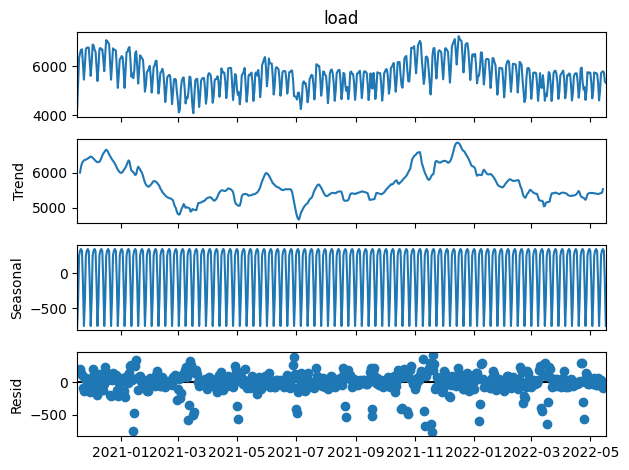

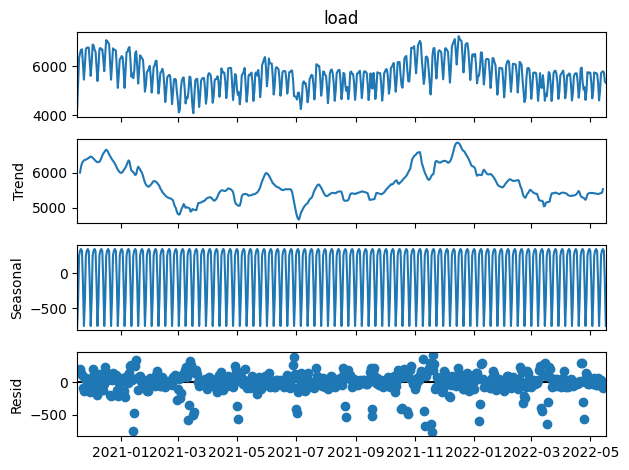

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(series,model='additive')
result.plot()


<Axes: xlabel='datetime'>

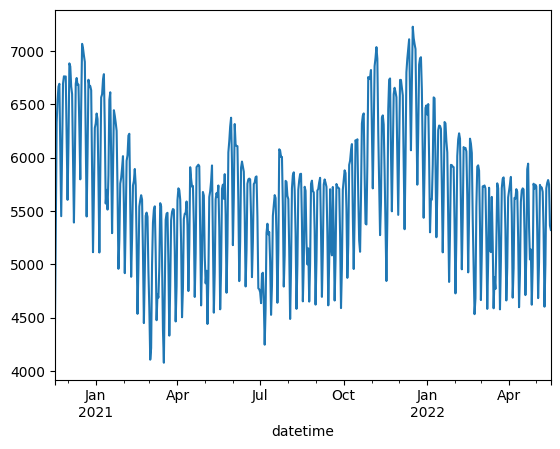

In [15]:
series.plot()

In [16]:
print(series.shape)
series.head()

(547,)


datetime
2020-11-17    4294.687500
2020-11-18    5373.125000
2020-11-19    6329.000000
2020-11-20    6538.708333
2020-11-21    6666.208333
Freq: D, Name: load, dtype: float64

### Teste de Estacionariedade:

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(time_series_data, column_name):
    result = adfuller(time_series_data[column_name])

    print(f"Resultados do Teste Dickey-Fuller Aumentado para a coluna '{column_name}':")
    print('-' * 50)
    print(f"Estatística ADF: {result[0]}")
    print(f"p-valor: {result[1]}")
    print("Número de lags utilizados:", result[2])
    print("Número de observações usadas:", result[3])
    print("Valores Críticos:")

    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] <= 0.05:
        print("Conclusão: A série é estacionária.")
    else:
        print("Conclusão: A série não é estacionária.")

# Suponha que 'data' é seu DataFrame e 'load' é a coluna que contém a série temporal
test_stationarity(data, 'load')



Resultados do Teste Dickey-Fuller Aumentado para a coluna 'load':
--------------------------------------------------
Estatística ADF: -12.438138860595265
p-valor: 3.806212302571636e-23
Número de lags utilizados: 38
Número de observações usadas: 13063
Valores Críticos:
	1%: -3.4308506955116695
	5%: -2.8617612833465675
	10%: -2.566887784202314
Conclusão: A série é estacionária.


## Tendencia

In [18]:
from pmdarima.arima import ndiffs

class TendencyTester:
    def __init__(self, series):
        self.series = series
        self.kpss_diffs = None
        self.adf_diffs = None

    def run_tests(self):
        self.kpss_diffs = ndiffs(self.series, test='kpss')
        self.adf_diffs = ndiffs(self.series, test='adf')
        self._print_results()

    def _print_results(self):
        print(f"Resultados dos testes para tendência na série:")
        print('-' * 50)
        print(f"Número de diferenciações sugeridas pelo teste KPSS: {self.kpss_diffs}")
        print(f"Número de diferenciações sugeridas pelo teste ADF (Dickey-Fuller Aumentado): {self.adf_diffs}")

    def is_tendency_present(self):
        return self.kpss_diffs > 0 or self.adf_diffs > 0

    def get_results(self):
        return {'kpss': self.kpss_diffs, 'adf': self.adf_diffs}

# Uso da classe
if __name__ == "__main__":
    # Suponha que 'series' é sua série temporal
    tester = TendencyTester(series)
    tester.run_tests()

    if tester.is_tendency_present():
        print("Conclusão: Há indicação de tendência na série.")
    else:
        print("Conclusão: Não há indicação de tendência na série.")



Resultados dos testes para tendência na série:
--------------------------------------------------
Número de diferenciações sugeridas pelo teste KPSS: 1
Número de diferenciações sugeridas pelo teste ADF (Dickey-Fuller Aumentado): 1
Conclusão: Há indicação de tendência na série.


### Médias Móveis

In [19]:
import pandas as pd
import plotly.graph_objects as go

def plot_time_series_with_moving_average(series, window_size):
    # Cálculo da média móvel
    series_moving_avg = series.rolling(window=window_size).mean()

    # Criação do gráfico
    fig = go.Figure()

    # Adicionar série original
    fig.add_trace(go.Scatter(x=series.index, y=series,
                             mode='lines',
                             name='Série Original'))

    # Adicionar média móvel
    fig.add_trace(go.Scatter(x=series_moving_avg.index, y=series_moving_avg,
                             mode='lines',
                             name=f'Média Móvel ({window_size} períodos)'))

    # Configurações adicionais do gráfico
    fig.update_layout(title=f'Série Temporal com Média Móvel de {window_size} Períodos',
                      xaxis_title='Tempo',
                      yaxis_title='Valor',
                      legend_title='Legenda',
                      template='plotly_dark')

    # Mostrar o gráfico
    fig.show()

# Chamada da função
plot_time_series_with_moving_average(series, window_size=24)


## heteroskedasticity

In [20]:
# heterocedastidade
from src.heteroskedasticity import het_tests

p_value = het_tests(series, test='white')
# p_value = het_tests(series, test='breuschpagan')

p_value


0.045620294339859604

# Questão 2

### ACF e PACF:

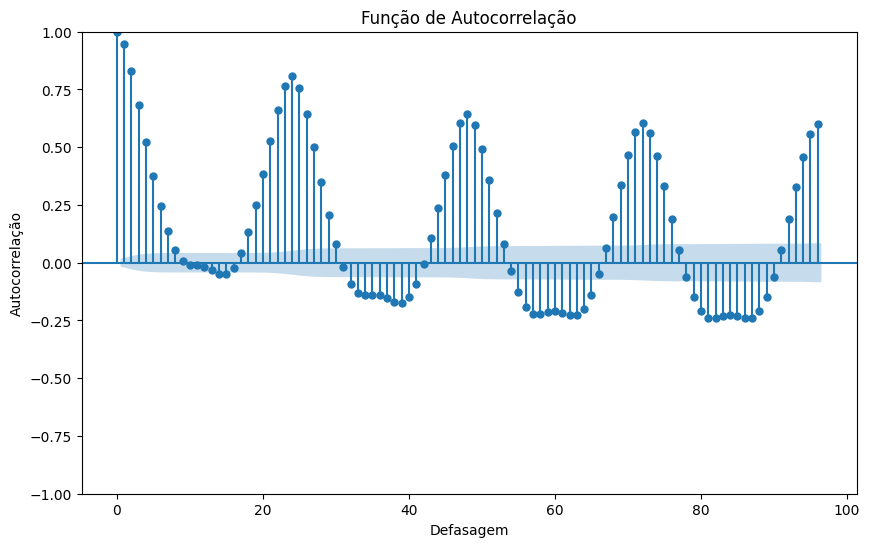

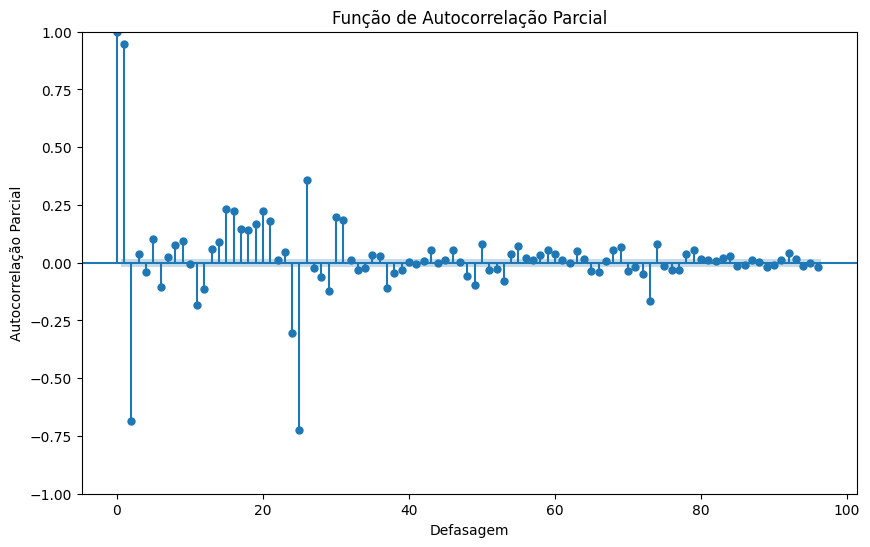

In [22]:
# Plotar a função de autocorrelação (ACF)
plt.figure(figsize=(10, 6))
plot_acf(data['load'], lags=96, ax=plt.gca())
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.title('Função de Autocorrelação')
plt.show()

# Plotar a função de autocorrelação parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(data['load'], lags=96, ax=plt.gca())
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.title('Função de Autocorrelação Parcial')
plt.show()


## 2- Descrever a estrutura ARIMA que melhor se adequa aos dados

## Abordagens

In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(series, test_size=48, shuffle=False)

### SARIMA

In [24]:
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_arima_model(data, seasonal=True, seasonal_periods=24, verbose=True):
    """
    Treina um modelo ARIMA usando pmdarima.auto_arima.
    Retorna o modelo treinado.
    """
    model = auto_arima(
        data,
        seasonal=seasonal,
        m=seasonal_periods,
        stepwise=True,
        trace=verbose
    )
    return model

def evaluate_model_performance(true_values, predicted_values):
    """
    Avalia o desempenho do modelo usando MAE e MSE.
    Retorna um dicionário contendo as métricas.
    """
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)

    metrics = {
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse
    }

    return metrics

if __name__ == "__main__":
    # Supondo que 'train' e 'test' já estão definidos como numpy.ndarray ou pandas.Series

    # Treinar o modelo nos últimos 100 pontos de dados
    model = train_arima_model(train.tail(100))

    # Fazer previsões para os próximos 48 períodos
    y_arima_forecast = model.predict(n_periods=48)

    # Avaliar o desempenho do modelo
    metrics = evaluate_model_performance(test, y_arima_forecast)

    for key, value in metrics.items():
        print(f"{key}: {value}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=1495.393, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1488.554, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=1467.031, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=1493.422, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=1466.029, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=1467.082, Time=0.39 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=1463.979, Time=0.12 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=1462.936, Time=0.73 sec
 ARIMA(1,1,1)(2,0,0)[24] intercept   : AIC=1464.878, Time=2.53 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept   : AIC=1465.069, Time=1.95 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=1463.061, Time=0.67 sec
 ARIMA(1,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=3.69 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept

### TBATS

In [25]:
import numpy as np
from tbats import TBATS

def calculate_mean_absolute_error(y_true, y_pred):
    """
    Calcula o Erro Médio Absoluto (MAE) entre os valores verdadeiros e previstos.

    Args:
    - y_true (np.array): Valores verdadeiros.
    - y_pred (np.array): Valores previstos.

    Returns:
    - float: Erro Médio Absoluto.
    """
    return np.mean(np.abs(y_true - y_pred))

def train_tbats_model(train_data, seasonal_periods=(24, 24 * 7)):
    """
    Treina um modelo TBATS.

    Args:
    - train_data (np.array): Dados de treinamento.
    - seasonal_periods (tuple): Períodos sazonais para o modelo TBATS.

    Returns:
    - TBATS model: Modelo treinado.
    """
    estimator = TBATS(seasonal_periods=seasonal_periods)
    return estimator.fit(train_data)

def main(train, test, seasonal_periods=(24, 24 * 7), forecast_steps=48):
    """
    Executa as operações principais: treina o modelo e faz a previsão.

    Args:
    - train (np.array): Dados de treinamento.
    - test (np.array): Dados de teste.
    - seasonal_periods (tuple): Períodos sazonais para o modelo TBATS.
    - forecast_steps (int): Número de passos para previsão.

    Returns:
    - None
    """

    # Verificações de erro para robustez
    if len(train) < 100:
        raise ValueError("Os dados de treinamento devem ter pelo menos 100 pontos.")

    if forecast_steps > len(test):
        raise ValueError("O número de etapas para previsão não pode ser maior do que o tamanho do conjunto de testes.")

    # Treinamento e previsão
    model = train_tbats_model(train[-100:], seasonal_periods)
    y_forecast = model.forecast(steps=forecast_steps)

    # Cálculo do erro
    error = calculate_mean_absolute_error(test[:forecast_steps], y_forecast)
    print(f"Erro Médio Absoluto: {error}")

if __name__ == "__main__":
    # Suponha que 'train' e 'test' sejam seus dados de treinamento e teste.
    # train = ...
    # test = ...

    main(train, test)


Erro Médio Absoluto: 320.45320027148495


### Prophet

In [27]:
from prophet import Prophet

model = Prophet(weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=True)

# é possível adicionar sazonalidades específicas
model = model.add_seasonality(name='monthly', period=24 * 7, fourier_order=10)


train_df = train.reset_index()
train_df.columns = ['ds', 'y']

#model.fit(train_df.tail(1000))
model.fit(train_df)

y_prophet_forecast = model.make_future_dataframe(periods=48,
                                       include_history=False,
                                       freq='H')
y_prophet_forecast = model.predict(y_prophet_forecast)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/c87ecmym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dp96fry8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87564', 'data', 'file=/tmp/tmpdtbqy1ug/c87ecmym.json', 'init=/tmp/tmpdtbqy1ug/dp96fry8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeli_iv_5at/prophet_model-20230908213712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:37:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:37:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


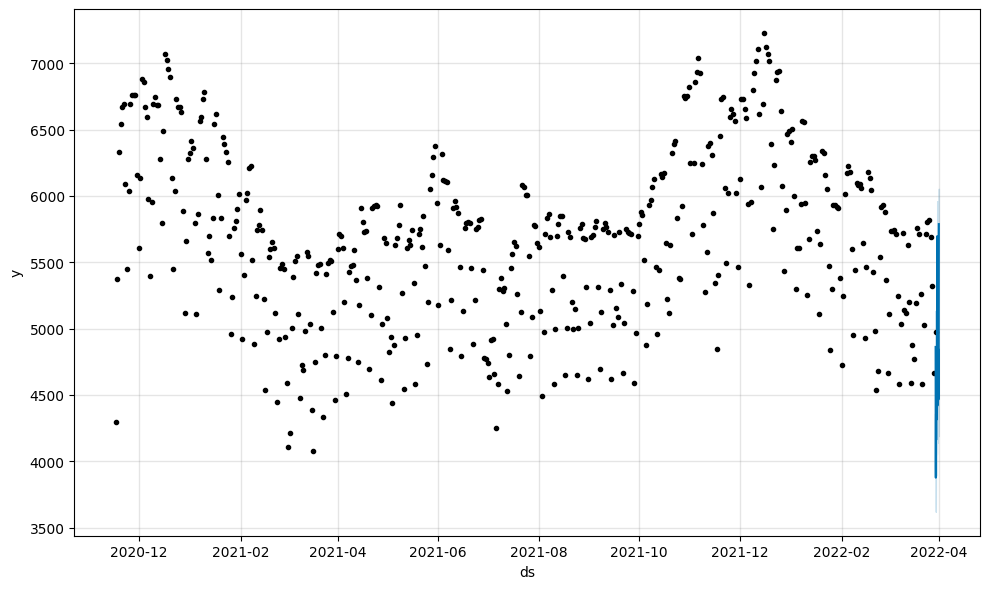

In [28]:
fig1 = model.plot(y_prophet_forecast)

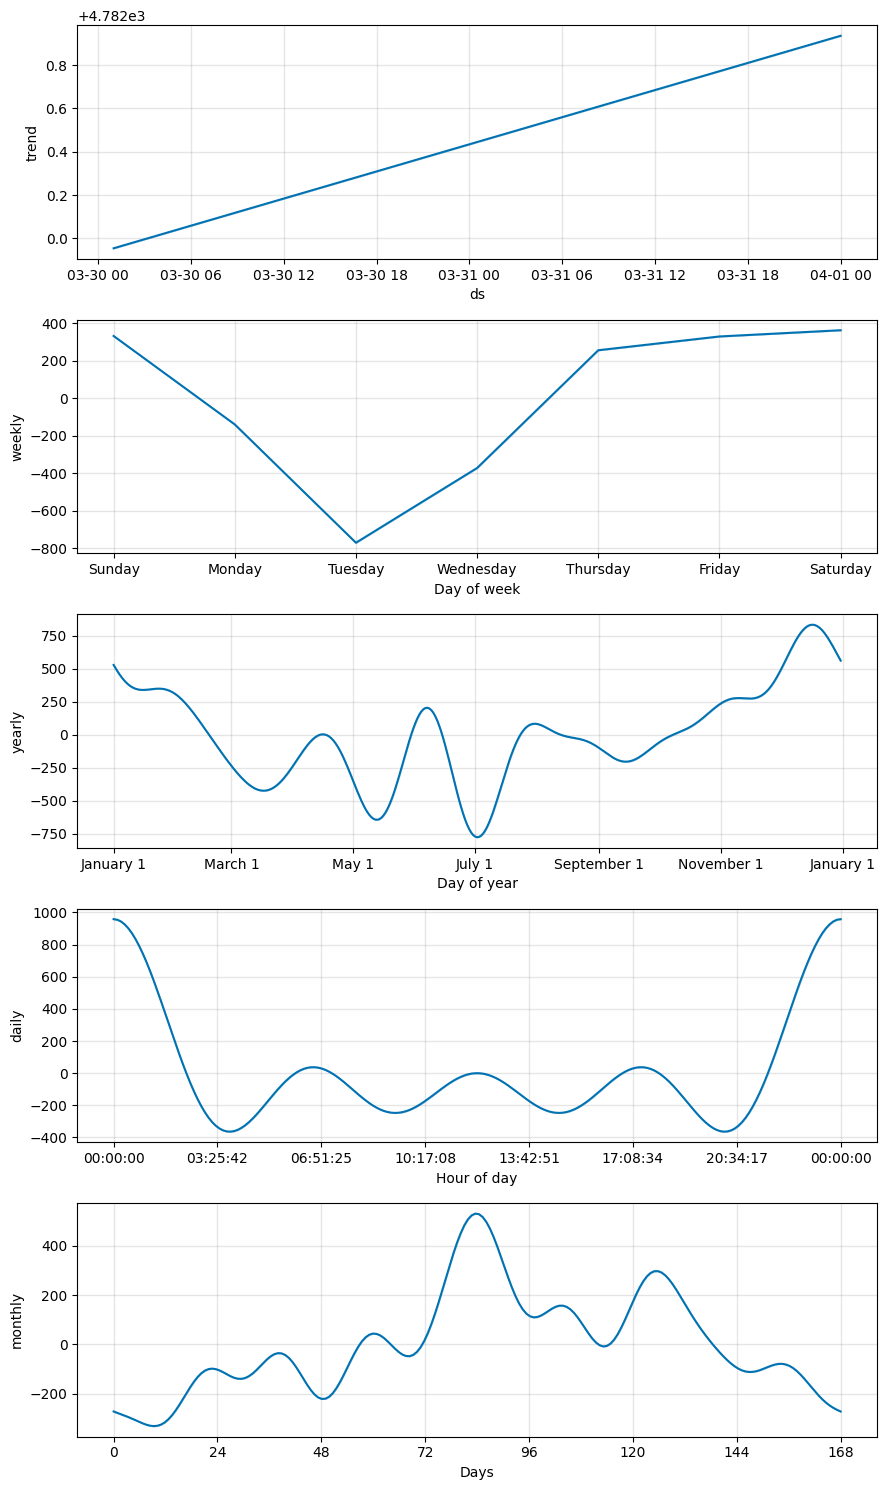

In [29]:
fig2 = model.plot_components(y_prophet_forecast)

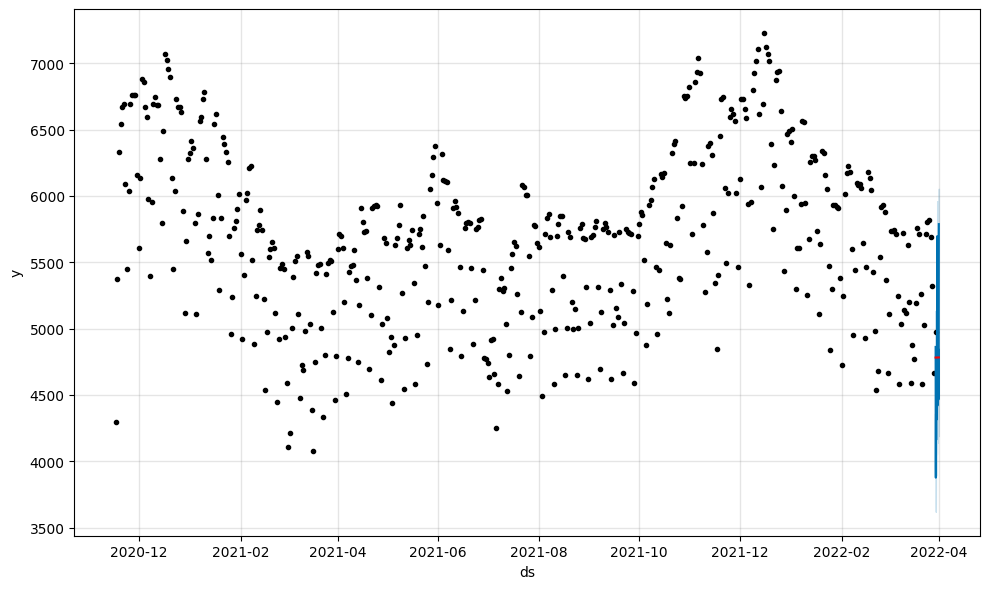

In [30]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(y_prophet_forecast)
a = add_changepoints_to_plot(fig.gca(), model, y_prophet_forecast)

In [31]:
print(np.mean(abs(test - y_prophet_forecast['yhat'].values)))

835.2099382466213


In [44]:
!pip install prophet


### Optimizing Prophet


In [43]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_absolute_error as mae
from src.prophet import optimize_prophet

# Definição da grade de parâmetros
params_grid = {'seasonality_mode': ['multiplicative', 'additive'],
               'growth': ['linear', 'flat'],
               'changepoint_prior_scale': [0.01, 0.1, 0.25, 0.5],
               'seasonality_prior_scale': [0.01, 0.5, 1, 5, 10],
               'n_changepoints': [0, 1, 2, 10]}

grid = ParameterGrid(params_grid)

# Divisão do conjunto de dados em treino e validação
train_in, validation = train_test_split(train, test_size=48, shuffle=False)

# Preparação do DataFrame de treinamento
train_in_df = train_in.reset_index()
train_in_df.columns = ['ds', 'y']

val_results = {'losses': [], 'params': []}

# Loop para ajuste e avaliação do modelo
for params in grid:
    print(params)
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    growth=params['growth'],
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=False,
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'])

    model = model.fit(train_in_df)

    forecast = model.make_future_dataframe(periods=48,
                                           include_history=False,
                                           freq='H')
    forecast = model.predict(forecast)
    forecast = forecast.filter(items=['ds', 'yhat'])

    loss = mae(validation, forecast['yhat'].values)

    val_results['losses'].append(loss)
    val_results['params'].append(params)

# Encontra o índice do menor MAE
idx_params = np.argmin(val_results['losses'])

# Pega o melhor conjunto de hiperparâmetros com base no menor MAE
best_params = val_results['params'][idx_params]

# Pega o menor MAE
best_loss = val_results['losses'][idx_params]

# Exibe o melhor conjunto de hiperparâmetros e o menor MAE
print(f"Melhor conjunto de hiperparâmetros: {best_params}")
print(f"Menor MAE: {best_loss}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/iimwoxsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qcxfe5er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56014', 'data', 'file=/tmp/tmpdtbqy1ug/iimwoxsw.json', 'init=/tmp/tmpdtbqy1ug/qcxfe5er.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeln7l46_uh/prophet_model-20230908221233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0kef8cbq.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hejzz0_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kx6at9kj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88326', 'data', 'file=/tmp/tmpdtbqy1ug/hejzz0_n.json', 'init=/tmp/tmpdtbqy1ug/kx6at9kj.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelp3sbk_x1/prophet_model-20230908221233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8zr1ywld.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ib4w6j6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jt_ucu79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91056', 'data', 'file=/tmp/tmpdtbqy1ug/ib4w6j6a.json', 'init=/tmp/tmpdtbqy1ug/jt_ucu79.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelc9o5pwz_/prophet_model-20230908221234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/yejb7wbq.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/d7spgg_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tg8ms7ji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74129', 'data', 'file=/tmp/tmpdtbqy1ug/d7spgg_y.json', 'init=/tmp/tmpdtbqy1ug/tg8ms7ji.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelhf0bxuui/prophet_model-20230908221234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lgj1966_.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/n52gmi22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/62zodrr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32632', 'data', 'file=/tmp/tmpdtbqy1ug/n52gmi22.json', 'init=/tmp/tmpdtbqy1ug/62zodrr0.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelwovcr6tl/prophet_model-20230908221234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kz6o_82c.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mlpo6lmk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rnxxw4on.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60030', 'data', 'file=/tmp/tmpdtbqy1ug/mlpo6lmk.json', 'init=/tmp/tmpdtbqy1ug/rnxxw4on.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model1i_hzogj/prophet_model-20230908221234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8eassw38.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/h78jkp92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ohq5nfbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87734', 'data', 'file=/tmp/tmpdtbqy1ug/h78jkp92.json', 'init=/tmp/tmpdtbqy1ug/ohq5nfbo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model640ab5rm/prophet_model-20230908221235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/sg72cfzn.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mvseuprb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dx44vk7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40788', 'data', 'file=/tmp/tmpdtbqy1ug/mvseuprb.json', 'init=/tmp/tmpdtbqy1ug/dx44vk7y.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelfrxnkv2v/prophet_model-20230908221235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/81v7e9ac.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2rkr88ns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/krkmle4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92279', 'data', 'file=/tmp/tmpdtbqy1ug/2rkr88ns.json', 'init=/tmp/tmpdtbqy1ug/krkmle4b.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeltv4nrz26/prophet_model-20230908221235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5r2cx8af.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2m57eydb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jq1z2i02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91332', 'data', 'file=/tmp/tmpdtbqy1ug/2m57eydb.json', 'init=/tmp/tmpdtbqy1ug/jq1z2i02.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model9ivp1f2c/prophet_model-20230908221235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2a4dnona.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1xqd6ywp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/yeo56ry_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29004', 'data', 'file=/tmp/tmpdtbqy1ug/1xqd6ywp.json', 'init=/tmp/tmpdtbqy1ug/yeo56ry_.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelj3_g729w/prophet_model-20230908221236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kdnm3wbw.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/j2s8r7ie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6a3zre1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94374', 'data', 'file=/tmp/tmpdtbqy1ug/j2s8r7ie.json', 'init=/tmp/tmpdtbqy1ug/6a3zre1z.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelll_0i_me/prophet_model-20230908221236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ycym7gmy.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ycb3d6nx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e_vk1zn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51219', 'data', 'file=/tmp/tmpdtbqy1ug/ycb3d6nx.json', 'init=/tmp/tmpdtbqy1ug/e_vk1zn0.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelu0nvmqbe/prophet_model-20230908221236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/t73zz3wj.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2fbidh7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pykl9xgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93370', 'data', 'file=/tmp/tmpdtbqy1ug/2fbidh7e.json', 'init=/tmp/tmpdtbqy1ug/pykl9xgf.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelf4sjxdoz/prophet_model-20230908221236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/o59c2gvd.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/n65mjyda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/owdoc14i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58543', 'data', 'file=/tmp/tmpdtbqy1ug/n65mjyda.json', 'init=/tmp/tmpdtbqy1ug/owdoc14i.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelykljuy5u/prophet_model-20230908221237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_e0x4n_d.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wvw55y63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/80yxgvod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3141', 'data', 'file=/tmp/tmpdtbqy1ug/wvw55y63.json', 'init=/tmp/tmpdtbqy1ug/80yxgvod.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model8y4qo4z1/prophet_model-20230908221237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/r296b7v7.json
DEB

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nwr4_dxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2uf8w7j5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30542', 'data', 'file=/tmp/tmpdtbqy1ug/nwr4_dxz.json', 'init=/tmp/tmpdtbqy1ug/2uf8w7j5.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelx9in4usk/prophet_model-20230908221237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lcjewpz2.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/499ypxhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wrk3zfht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90550', 'data', 'file=/tmp/tmpdtbqy1ug/499ypxhq.json', 'init=/tmp/tmpdtbqy1ug/wrk3zfht.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelewqktm41/prophet_model-20230908221237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vw4m5x9o.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/f6sru4_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5i2yye04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83340', 'data', 'file=/tmp/tmpdtbqy1ug/f6sru4_j.json', 'init=/tmp/tmpdtbqy1ug/5i2yye04.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeluhq2dmy9/prophet_model-20230908221238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vpd25it_.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_88gfxas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/v3iheywv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12687', 'data', 'file=/tmp/tmpdtbqy1ug/_88gfxas.json', 'init=/tmp/tmpdtbqy1ug/v3iheywv.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelpi44baot/prophet_model-20230908221238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/r3w48a91.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/03ntwqyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/c4tk27b_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46779', 'data', 'file=/tmp/tmpdtbqy1ug/03ntwqyv.json', 'init=/tmp/tmpdtbqy1ug/c4tk27b_.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model1qcvw04b/prophet_model-20230908221238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/g3t45ilx.json


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mzxdz74f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80106', 'data', 'file=/tmp/tmpdtbqy1ug/g3t45ilx.json', 'init=/tmp/tmpdtbqy1ug/mzxdz74f.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelrc7xfziz/prophet_model-20230908221238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tp4dinyu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6oltefn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8610', 'data', 'file=/tmp/tmpdtbqy1ug/ltleeei_.json', 'init=/tmp/tmpdtbqy1ug/ay6c_0kg.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelid1gy0lx/prophet_model-20230908221238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/m7tv2_e4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tp305zeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83920', 'data', 'file=/tmp/tmpdtbqy1ug/m7tv

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11743', 'data', 'file=/tmp/tmpdtbqy1ug/2yukw0mr.json', 'init=/tmp/tmpdtbqy1ug/w9ibwzdi.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeluaq3_r03/prophet_model-20230908221239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vc21kokh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4g0_fwux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/faifv1uq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2o0d0si6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19335', 'data', 'file=/tmp/tmpdtbqy1ug/faifv1uq.json', 'init=/tmp/tmpdtbqy1ug/2o0d0si6.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelz0gx6qmj/prophet_model-20230908221239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vddzvi43.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e119yrxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/49x1u_e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73206', 'data', 'file=/tmp/tmpdtbqy1ug/e119yrxf.json', 'init=/tmp/tmpdtbqy1ug/49x1u_e2.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelvj2m_mnr/prophet_model-20230908221240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ankfxb43.json
DE

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


22:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dr6z38vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/abborrxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69204', 'data', 'file=/tmp/tmpdtbqy1ug/dr6z38vi.json', 'init=/tmp/tmpdtbqy1ug/abborrxa.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelzg4t06tl/prophet_model-20230908221240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e88b9jw9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hdeb15ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85191', 'data', 'file=/tmp/tmpdtbqy1ug/e88b9jw9.json', 'init=/tmp/tmpdtbqy1ug/hdeb15ta.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeliu93a9gj/prophet_model-20230908221240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/50pnri9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ptev4g4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


22:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4qky4fd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9kyacvfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47986', 'data', 'file=/tmp/tmpdtbqy1ug/4qky4fd2.json', 'init=/tmp/tmpdtbqy1ug/9kyacvfr.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model13h0ccnz/prophet_model-20230908221240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/85ju2qze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uj3cj0z9.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


22:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vc7tp7bl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bd_ggvvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51423', 'data', 'file=/tmp/tmpdtbqy1ug/vc7tp7bl.json', 'init=/tmp/tmpdtbqy1ug/bd_ggvvn.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeldyvc3oxy/prophet_model-20230908221241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nu4r4zlf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mi7wajye.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


22:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/274ncz3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/yd0z1et9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75128', 'data', 'file=/tmp/tmpdtbqy1ug/274ncz3i.json', 'init=/tmp/tmpdtbqy1ug/yd0z1et9.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelopwsrh9z/prophet_model-20230908221241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/y80guajb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xgqpxwh7.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/w4igb5n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lzjr88w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11868', 'data', 'file=/tmp/tmpdtbqy1ug/w4igb5n_.json', 'init=/tmp/tmpdtbqy1ug/lzjr88w8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeld4cm9bpo/prophet_model-20230908221241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zlhtgfyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/itw6q_jq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5_9lnhge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tnp0l47j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8958', 'data', 'file=/tmp/tmpdtbqy1ug/5_9lnhge.json', 'init=/tmp/tmpdtbqy1ug/tnp0l47j.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model7gvgmv3m/prophet_model-20230908221241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nhka5a95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bywhhp8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ojwrylco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/oihkeqx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77649', 'data', 'file=/tmp/tmpdtbqy1ug/ojwrylco.json', 'init=/tmp/tmpdtbqy1ug/oihkeqx4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelpmfpq7hs/prophet_model-20230908221242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3ac3a0y5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3_z7esnh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/htrrvwok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jgrbwen0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93602', 'data', 'file=/tmp/tmpdtbqy1ug/htrrvwok.json', 'init=/tmp/tmpdtbqy1ug/jgrbwen0.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model1ngxi6tm/prophet_model-20230908221242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zsimrcjg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zlriqzo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/twpvw2q3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bpxhvmti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55976', 'data', 'file=/tmp/tmpdtbqy1ug/twpvw2q3.json', 'init=/tmp/tmpdtbqy1ug/bpxhvmti.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model28pvpb9j/prophet_model-20230908221242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dtokom4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e727cu3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pi0zai_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/edh1vyo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82994', 'data', 'file=/tmp/tmpdtbqy1ug/pi0zai_r.json', 'init=/tmp/tmpdtbqy1ug/edh1vyo3.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelpi3c4qr5/prophet_model-20230908221242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_47n5uua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bqw2m_r9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fk1_bkzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1upml_34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67135', 'data', 'file=/tmp/tmpdtbqy1ug/fk1_bkzk.json', 'init=/tmp/tmpdtbqy1ug/1upml_34.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeloeg_rvi_/prophet_model-20230908221243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8oluun5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z18w5joa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_5zk_ko5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/x424v2bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81771', 'data', 'file=/tmp/tmpdtbqy1ug/_5zk_ko5.json', 'init=/tmp/tmpdtbqy1ug/x424v2bq.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model6v72wy5n/prophet_model-20230908221243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mmtxz3jf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ixele7da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nozqpc9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pi_fw56z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78285', 'data', 'file=/tmp/tmpdtbqy1ug/nozqpc9o.json', 'init=/tmp/tmpdtbqy1ug/pi_fw56z.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelnhp_taty/prophet_model-20230908221243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0z3uk146.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/g_vb_m89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ym9bqv6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xba92b_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96904', 'data', 'file=/tmp/tmpdtbqy1ug/ym9bqv6n.json', 'init=/tmp/tmpdtbqy1ug/xba92b_k.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelweoacv4t/prophet_model-20230908221243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ar6vkmlt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nt_3sqzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rr1ro53l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/sqae0nge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19129', 'data', 'file=/tmp/tmpdtbqy1ug/rr1ro53l.json', 'init=/tmp/tmpdtbqy1ug/sqae0nge.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model924_yygn/prophet_model-20230908221243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qnocrt9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zcfzgmlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zw2u509w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/85eosk7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=240', 'data', 'file=/tmp/tmpdtbqy1ug/zw2u509w.json', 'init=/tmp/tmpdtbqy1ug/85eosk7f.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelurs2ut34/prophet_model-20230908221244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jjrgz2qd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jme57ma8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dy7cwinq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8d39nche.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53401', 'data', 'file=/tmp/tmpdtbqy1ug/dy7cwinq.json', 'init=/tmp/tmpdtbqy1ug/8d39nche.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelhu6ziacr/prophet_model-20230908221244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/r0mm0nns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ox8i80_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8xrnihm5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jy_r09iv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85705', 'data', 'file=/tmp/tmpdtbqy1ug/8xrnihm5.json', 'init=/tmp/tmpdtbqy1ug/jy_r09iv.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelc70jibez/prophet_model-20230908221244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/p542hf3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xq48e4mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ds1m_2iz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jkneshm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85596', 'data', 'file=/tmp/tmpdtbqy1ug/ds1m_2iz.json', 'init=/tmp/tmpdtbqy1ug/jkneshm5.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelnviwntn5/prophet_model-20230908221244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8cu1kxjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jorq5wrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nqx6scc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ltg7qmgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96047', 'data', 'file=/tmp/tmpdtbqy1ug/nqx6scc_.json', 'init=/tmp/tmpdtbqy1ug/ltg7qmgx.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model33pm2h7y/prophet_model-20230908221245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gchk7bfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z5piijie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2jjw1xv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/40tcnp42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27639', 'data', 'file=/tmp/tmpdtbqy1ug/2jjw1xv5.json', 'init=/tmp/tmpdtbqy1ug/40tcnp42.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model87d8_mxr/prophet_model-20230908221245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2b8bgs8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/148e295j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/yq04j9zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8k4z07az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5658', 'data', 'file=/tmp/tmpdtbqy1ug/yq04j9zv.json', 'init=/tmp/tmpdtbqy1ug/8k4z07az.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modellltz1tnp/prophet_model-20230908221245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/snvn9stj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/plg4foq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2_8hc08g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_rn_ykny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1839', 'data', 'file=/tmp/tmpdtbqy1ug/2_8hc08g.json', 'init=/tmp/tmpdtbqy1ug/_rn_ykny.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeli_kjw09n/prophet_model-20230908221246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pku37fzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8us3tynt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/t2m1cs3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_0xpmcyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90164', 'data', 'file=/tmp/tmpdtbqy1ug/t2m1cs3m.json', 'init=/tmp/tmpdtbqy1ug/_0xpmcyr.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelafoyzeh0/prophet_model-20230908221246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5mfiix24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nphuiaql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/b52_iodl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tqv0r3w0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95969', 'data', 'file=/tmp/tmpdtbqy1ug/b52_iodl.json', 'init=/tmp/tmpdtbqy1ug/tqv0r3w0.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelgri4uo08/prophet_model-20230908221246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2ffim01e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/80mygop6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/b9ju_g3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/a23u0y4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90941', 'data', 'file=/tmp/tmpdtbqy1ug/b9ju_g3p.json', 'init=/tmp/tmpdtbqy1ug/a23u0y4k.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelg0u4o6gp/prophet_model-20230908221246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/f606vaq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qe7kpisw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8lmp27p2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/a59aa7fr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40597', 'data', 'file=/tmp/tmpdtbqy1ug/8lmp27p2.json', 'init=/tmp/tmpdtbqy1ug/a59aa7fr.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeli4ippy8x/prophet_model-20230908221246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vf3kolxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_c7hvd70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vekklsss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bks_ctbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51865', 'data', 'file=/tmp/tmpdtbqy1ug/vekklsss.json', 'init=/tmp/tmpdtbqy1ug/bks_ctbl.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeln_hx4f9a/prophet_model-20230908221247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4fps821g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ucedpw1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ismcrxx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uhrra0d9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50539', 'data', 'file=/tmp/tmpdtbqy1ug/ismcrxx_.json', 'init=/tmp/tmpdtbqy1ug/uhrra0d9.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model6kp4medy/prophet_model-20230908221247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/siqbjrd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4pr1m563.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4p8yvjnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jp3gtzys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47462', 'data', 'file=/tmp/tmpdtbqy1ug/4p8yvjnv.json', 'init=/tmp/tmpdtbqy1ug/jp3gtzys.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeln3v0t4jv/prophet_model-20230908221247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ug7tlca3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/u9z9mvv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_lrkncuz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9h1mj6a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91975', 'data', 'file=/tmp/tmpdtbqy1ug/_lrkncuz.json', 'init=/tmp/tmpdtbqy1ug/9h1mj6a4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelkpl9jx4k/prophet_model-20230908221247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rwf5xg3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0on_0xia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/aacx3z7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/j9hn99fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3486', 'data', 'file=/tmp/tmpdtbqy1ug/aacx3z7j.json', 'init=/tmp/tmpdtbqy1ug/j9hn99fc.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelo5_wlzm3/prophet_model-20230908221248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xiy8txcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4ql27pah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hxfhhp46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/55fj4s9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43822', 'data', 'file=/tmp/tmpdtbqy1ug/hxfhhp46.json', 'init=/tmp/tmpdtbqy1ug/55fj4s9q.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeltbzjunfe/prophet_model-20230908221248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ny_3vnub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hu98zdh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


22:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wvxvml26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nvzpyoge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35592', 'data', 'file=/tmp/tmpdtbqy1ug/wvxvml26.json', 'init=/tmp/tmpdtbqy1ug/nvzpyoge.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeljwigd_um/prophet_model-20230908221248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1cxb7jf5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vv4vhcw8.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


22:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kx5a0bdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xt_15j0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5727', 'data', 'file=/tmp/tmpdtbqy1ug/kx5a0bdq.json', 'init=/tmp/tmpdtbqy1ug/xt_15j0w.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeldpkaxgvp/prophet_model-20230908221249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mfjhl7cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ieiemzju.json
DEBUG:cmdstanpy:idx 

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/44k7hjis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5vqouh31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54647', 'data', 'file=/tmp/tmpdtbqy1ug/44k7hjis.json', 'init=/tmp/tmpdtbqy1ug/5vqouh31.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model92_ues5u/prophet_model-20230908221249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9c2fdqnl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/96xttbay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/q8an74cw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/so65pfzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63869', 'data', 'file=/tmp/tmpdtbqy1ug/q8an74cw.json', 'init=/tmp/tmpdtbqy1ug/so65pfzr.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeley5h9uka/prophet_model-20230908221249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/n2gr8quo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/98ycgha8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


22:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hxkn7qff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gcjmvblo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11768', 'data', 'file=/tmp/tmpdtbqy1ug/hxkn7qff.json', 'init=/tmp/tmpdtbqy1ug/gcjmvblo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model_mi6q1oo/prophet_model-20230908221249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


22:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xpujrl0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1zhdy03g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41089', 'data', 'file=/tmp/tmpdtbqy1ug/xpujrl0g.json', 'init=/tmp/tmpdtbqy1ug/1zhdy03g.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelhn0s4q7q/prophet_model-20230908221250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


22:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/yix_ztvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jthmo7zk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3366', 'data', 'file=/tmp/tmpdtbqy1ug/yix_ztvw.json', 'init=/tmp/tmpdtbqy1ug/jthmo7zk.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelvwargp5i/prophet_model-20230908221250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


22:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/t50cj_dj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lyhmba81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90256', 'data', 'file=/tmp/tmpdtbqy1ug/t50cj_dj.json', 'init=/tmp/tmpdtbqy1ug/lyhmba81.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelgo9aplc5/prophet_model-20230908221250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


22:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3gsz3yk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ldnefx3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61033', 'data', 'file=/tmp/tmpdtbqy1ug/3gsz3yk0.json', 'init=/tmp/tmpdtbqy1ug/ldnefx3r.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelsnzt_ero/prophet_model-20230908221250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9zd80gqc.json


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dyef0nxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11246', 'data', 'file=/tmp/tmpdtbqy1ug/9zd80gqc.json', 'init=/tmp/tmpdtbqy1ug/dyef0nxz.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model6oee3_1f/prophet_model-20230908221251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pp8lc90o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/x8_swwxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ww6pdssk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9327', 'data', 'file=/tmp/tmpdtbqy1ug/cuceju9c.json', 'init=/tmp/tmpdtbqy1ug/ww6pdssk.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeliesq643m/prophet_model-20230908221251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8mcf3dls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jdnns0k9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bi

{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88865', 'data', 'file=/tmp/tmpdtbqy1ug/uebg0otp.json', 'init=/tmp/tmpdtbqy1ug/j622g2tw.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelkgc9w8it/prophet_model-20230908221251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ten9yq14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/sv7xe3cj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61910', 'data', 'file=/tmp/tmpdtbqy1ug/ten9yq14.json', 'init=/tmp/tmpdtbqy1ug/sv7xe3cj.json', 'output', 'file=/tmp/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/214lg7c4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_4u9x9vc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6614', 'data', 'file=/tmp/tmpdtbqy1ug/214lg7c4.json', 'init=/tmp/tmpdtbqy1ug/_4u9x9vc.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelypk5udox/prophet_model-20230908221252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/luy_3ytg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e81vl65o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qrvqf6jw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/t8z4qu6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18453', 'data', 'file=/tmp/tmpdtbqy1ug/qrvqf6jw.json', 'init=/tmp/tmpdtbqy1ug/t8z4qu6z.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model5ceaycda/prophet_model-20230908221252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fiv9axm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/70tzo7qq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/s8af4s3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/n64bzc7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77757', 'data', 'file=/tmp/tmpdtbqy1ug/s8af4s3b.json', 'init=/tmp/tmpdtbqy1ug/n64bzc7s.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeljhvf5i28/prophet_model-20230908221252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7nujzjcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3_t9n358.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gzb4_uj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8vp_44pc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98066', 'data', 'file=/tmp/tmpdtbqy1ug/gzb4_uj9.json', 'init=/tmp/tmpdtbqy1ug/8vp_44pc.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model42ywxx6m/prophet_model-20230908221252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5xzk5qbt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gsz_ix5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uss9_co5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tt8co_ce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65698', 'data', 'file=/tmp/tmpdtbqy1ug/uss9_co5.json', 'init=/tmp/tmpdtbqy1ug/tt8co_ce.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelas9wq_e3/prophet_model-20230908221253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/phelh84c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9c89rwf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/w44iihql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/264rok8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43386', 'data', 'file=/tmp/tmpdtbqy1ug/w44iihql.json', 'init=/tmp/tmpdtbqy1ug/264rok8a.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model6ofstkj4/prophet_model-20230908221253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/s02_lq7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0w6tldaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9kwbkjs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4z448v1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96857', 'data', 'file=/tmp/tmpdtbqy1ug/9kwbkjs3.json', 'init=/tmp/tmpdtbqy1ug/4z448v1j.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelt90k3k2x/prophet_model-20230908221253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vsco5kzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ku98fjqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nj5pyhgh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/cddgajhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47073', 'data', 'file=/tmp/tmpdtbqy1ug/nj5pyhgh.json', 'init=/tmp/tmpdtbqy1ug/cddgajhp.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelnsm1dgz4/prophet_model-20230908221253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/j85agzcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/98m4tqht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/l_kghg9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/s7gm3fjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98799', 'data', 'file=/tmp/tmpdtbqy1ug/l_kghg9g.json', 'init=/tmp/tmpdtbqy1ug/s7gm3fjd.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeldm4yd9bi/prophet_model-20230908221254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/a4gn8lzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/j_dbwhgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/m03tr86q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rahigk8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99591', 'data', 'file=/tmp/tmpdtbqy1ug/m03tr86q.json', 'init=/tmp/tmpdtbqy1ug/rahigk8b.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model9xlajr0c/prophet_model-20230908221254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rcjbxv2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z8ys7y0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uff4dv3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/v_64mjn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11852', 'data', 'file=/tmp/tmpdtbqy1ug/uff4dv3x.json', 'init=/tmp/tmpdtbqy1ug/v_64mjn6.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelzvj_5okt/prophet_model-20230908221254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0_grwfoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kmt8ai7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/sxbcjp15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3tpfqm6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58498', 'data', 'file=/tmp/tmpdtbqy1ug/sxbcjp15.json', 'init=/tmp/tmpdtbqy1ug/3tpfqm6f.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelrdgxl3pj/prophet_model-20230908221254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dtxr1m6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ozfdu5f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/46vwhy4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qxiyol3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38871', 'data', 'file=/tmp/tmpdtbqy1ug/46vwhy4d.json', 'init=/tmp/tmpdtbqy1ug/qxiyol3d.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model9o5lr2r4/prophet_model-20230908221255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/um86s98m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/cij8c27m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6hxxxa_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/a1ud8ylo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91047', 'data', 'file=/tmp/tmpdtbqy1ug/6hxxxa_z.json', 'init=/tmp/tmpdtbqy1ug/a1ud8ylo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelgkvnn30d/prophet_model-20230908221255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/em_3ggd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/h6np97w4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/h59a5xsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mdnuyjq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96972', 'data', 'file=/tmp/tmpdtbqy1ug/h59a5xsq.json', 'init=/tmp/tmpdtbqy1ug/mdnuyjq7.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeljxc3z3e9/prophet_model-20230908221255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0ihgpu6q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qj2vprfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


22:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/btcwxe0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/r8ovy38q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52088', 'data', 'file=/tmp/tmpdtbqy1ug/btcwxe0n.json', 'init=/tmp/tmpdtbqy1ug/r8ovy38q.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model8rgv909d/prophet_model-20230908221256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


22:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rrv2x6zg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2y7nvn0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59332', 'data', 'file=/tmp/tmpdtbqy1ug/rrv2x6zg.json', 'init=/tmp/tmpdtbqy1ug/2y7nvn0f.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelaf_mdqkq/prophet_model-20230908221256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


22:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_crsz22s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/envu2vp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54333', 'data', 'file=/tmp/tmpdtbqy1ug/_crsz22s.json', 'init=/tmp/tmpdtbqy1ug/envu2vp4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelca_c1d36/prophet_model-20230908221257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


22:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3caxgaq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/66co30zg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4214', 'data', 'file=/tmp/tmpdtbqy1ug/3caxgaq_.json', 'init=/tmp/tmpdtbqy1ug/66co30zg.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeliofldpsc/prophet_model-20230908221257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during proc

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


22:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9_2p2y_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7fyzf7z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5796', 'data', 'file=/tmp/tmpdtbqy1ug/9_2p2y_k.json', 'init=/tmp/tmpdtbqy1ug/7fyzf7z_.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modela2zpd3lc/prophet_model-20230908221257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during proc

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/sue2o349.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9cs8sb_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96411', 'data', 'file=/tmp/tmpdtbqy1ug/sue2o349.json', 'init=/tmp/tmpdtbqy1ug/9cs8sb_f.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelha83vhep/prophet_model-20230908221258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/l46ujibh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5oyzygiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52430', 'data', 'file=/tmp/tmpdtbqy1ug/l46ujibh.json', 'init=/tmp/tmpdtbqy1ug/5oyzygiz.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelpep7_bqo/prophet_model-20230908221258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z390qej0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/krla38jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88303', 'data', 'file=/tmp/tmpdtbqy1ug/z390qej0.json', 'init=/tmp/tmpdtbqy1ug/krla38jb.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelbkefaa5m/prophet_model-20230908221258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


22:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7ph26b8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ezxmyluh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85491', 'data', 'file=/tmp/tmpdtbqy1ug/7ph26b8v.json', 'init=/tmp/tmpdtbqy1ug/ezxmyluh.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model40ad8r1d/prophet_model-20230908221259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:12:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


22:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bx4hp3_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nytqehzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43969', 'data', 'file=/tmp/tmpdtbqy1ug/bx4hp3_b.json', 'init=/tmp/tmpdtbqy1ug/nytqehzm.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelxtxwrr26/prophet_model-20230908221259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ewehrg8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2r1uo3sl.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2a69oe2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ps2pgtt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23814', 'data', 'file=/tmp/tmpdtbqy1ug/2a69oe2l.json', 'init=/tmp/tmpdtbqy1ug/ps2pgtt4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model_exl2y6v/prophet_model-20230908221259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/717t15he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/j95r5j6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/x27pq2fa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qdje5jpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55028', 'data', 'file=/tmp/tmpdtbqy1ug/x27pq2fa.json', 'init=/tmp/tmpdtbqy1ug/qdje5jpv.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelmdhghjq1/prophet_model-20230908221259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pjvda5wo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uwq3p9uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/18rjk8yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/w_ybvs_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49527', 'data', 'file=/tmp/tmpdtbqy1ug/18rjk8yp.json', 'init=/tmp/tmpdtbqy1ug/w_ybvs_5.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelzeha2ofh/prophet_model-20230908221300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/efvc5zhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ul7a8lej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8m3j59lw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3t_fj9_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36927', 'data', 'file=/tmp/tmpdtbqy1ug/8m3j59lw.json', 'init=/tmp/tmpdtbqy1ug/3t_fj9_8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelr03xl0q5/prophet_model-20230908221300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0narsojr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/if1t__7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1wng1zbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/y8a2j0vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68036', 'data', 'file=/tmp/tmpdtbqy1ug/1wng1zbl.json', 'init=/tmp/tmpdtbqy1ug/y8a2j0vz.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelo6uwf9b4/prophet_model-20230908221300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kqaoosqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/d0vdle7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


22:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/aup73o8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/l9sdmf0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65294', 'data', 'file=/tmp/tmpdtbqy1ug/aup73o8h.json', 'init=/tmp/tmpdtbqy1ug/l9sdmf0r.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model7p9nma9z/prophet_model-20230908221300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wz29lzgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/equu637b.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


22:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9m69kg27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dq2r54o4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19307', 'data', 'file=/tmp/tmpdtbqy1ug/9m69kg27.json', 'init=/tmp/tmpdtbqy1ug/dq2r54o4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelbabteu_z/prophet_model-20230908221301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/k4swg59y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/i0kjeu3c.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/l54qm9lu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wkh_27ot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43634', 'data', 'file=/tmp/tmpdtbqy1ug/l54qm9lu.json', 'init=/tmp/tmpdtbqy1ug/wkh_27ot.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelv5sqs_5y/prophet_model-20230908221301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e7khequ0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8bp1nryx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/s5pr5wms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uwzo07qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22464', 'data', 'file=/tmp/tmpdtbqy1ug/s5pr5wms.json', 'init=/tmp/tmpdtbqy1ug/uwzo07qm.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelrno0cvpv/prophet_model-20230908221301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bfaxrs8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1_db02yk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rd3vtbri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gxg44e21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70537', 'data', 'file=/tmp/tmpdtbqy1ug/rd3vtbri.json', 'init=/tmp/tmpdtbqy1ug/gxg44e21.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelv8_k31xq/prophet_model-20230908221301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


22:13:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4fn2nxr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fbrk8r1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9898', 'data', 'file=/tmp/tmpdtbqy1ug/4fn2nxr2.json', 'init=/tmp/tmpdtbqy1ug/fbrk8r1_.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelh22fji4a/prophet_model-20230908221302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


22:13:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4fcbylk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rtsgcby8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86964', 'data', 'file=/tmp/tmpdtbqy1ug/4fcbylk9.json', 'init=/tmp/tmpdtbqy1ug/rtsgcby8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelt6u96b90/prophet_model-20230908221302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:02 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/md28vxov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6d160qjb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65888', 'data', 'file=/tmp/tmpdtbqy1ug/md28vxov.json', 'init=/tmp/tmpdtbqy1ug/6d160qjb.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelmvnys8gm/prophet_model-20230908221302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z1qzuj1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vjdm61cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93858', 'data', 'file=/tmp/tmpdtbqy1ug/z1qzuj1_.json', 'init=/tmp/tmpdtbqy1ug/vjdm61cy.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelza97b_8k/prophet_model-20230908221302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/et326ncw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nlo418ty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88465', 'data', 'file=/tmp/tmpdtbqy1ug/et326ncw.json', 'init=/tmp/tmpdtbqy1ug/nlo418ty.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelblkiguau/prophet_model-20230908221303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/b5mumlh_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e5igskfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kjg0wba6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tylimbh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78633', 'data', 'file=/tmp/tmpdtbqy1ug/kjg0wba6.json', 'init=/tmp/tmpdtbqy1ug/tylimbh_.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model3e8dgbgu/prophet_model-20230908221303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_38jhhg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8vlbx92w.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/cnk7wok4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vra0t48d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35607', 'data', 'file=/tmp/tmpdtbqy1ug/cnk7wok4.json', 'init=/tmp/tmpdtbqy1ug/vra0t48d.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeliv1e9o8j/prophet_model-20230908221303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kwifltbz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/h0i3jsib.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35334', 'data', 'file=/tmp/tmpdtbqy1ug/kwifltbz.json', 'init=/tmp/tmpdtbqy1ug/h0i3jsib.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelxjeslvuk/prophet_model-20230908221303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bty1rg9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pjd8gbp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80856', 'data', 'file=/tmp/tmpdtbqy1ug/bty1rg9x.json', 'init=/tm

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/umvqmbpp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7pwg4cjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97443', 'data', 'file=/tmp/tmpdtbqy1ug/umvqmbpp.json', 'init=/tmp/tmpdtbqy1ug/7pwg4cjg.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelp0uhy2y7/prophet_model-20230908221304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3wst5wyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/et2pi9ut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9f5eeiro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3w2p7_tb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95921', 'data', 'file=/tmp/tmpdtbqy1ug/9f5eeiro.json', 'init=/tmp/tmpdtbqy1ug/3w2p7_tb.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelk9grq4li/prophet_model-20230908221304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vvf68fy4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/u_moai_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/k7q3p0or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2ebgogbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10706', 'data', 'file=/tmp/tmpdtbqy1ug/k7q3p0or.json', 'init=/tmp/tmpdtbqy1ug/2ebgogbi.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modela3g4flcy/prophet_model-20230908221304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hcdi_uco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/88_7x5xi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jero_6_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xgl9p548.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44110', 'data', 'file=/tmp/tmpdtbqy1ug/jero_6_m.json', 'init=/tmp/tmpdtbqy1ug/xgl9p548.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model0awf98ti/prophet_model-20230908221304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/peknekx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/o0ifjr6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/j_twjmgx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lurz5zer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79321', 'data', 'file=/tmp/tmpdtbqy1ug/j_twjmgx.json', 'init=/tmp/tmpdtbqy1ug/lurz5zer.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modela_0l55lw/prophet_model-20230908221305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/y2avdu2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/o6hz8rh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ktl7mm9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ozclhb16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87801', 'data', 'file=/tmp/tmpdtbqy1ug/ktl7mm9b.json', 'init=/tmp/tmpdtbqy1ug/ozclhb16.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modela2c1noyh/prophet_model-20230908221305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2oddvd_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/la8mnxmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uzyyk9pg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fu2_eqbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39573', 'data', 'file=/tmp/tmpdtbqy1ug/uzyyk9pg.json', 'init=/tmp/tmpdtbqy1ug/fu2_eqbx.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeld59n_60v/prophet_model-20230908221305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/w2w59ikq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/elj22sla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dio5woi5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dfgdm7yo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25998', 'data', 'file=/tmp/tmpdtbqy1ug/dio5woi5.json', 'init=/tmp/tmpdtbqy1ug/dfgdm7yo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelm7r2_s9i/prophet_model-20230908221305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/m4xo3989.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/28f18e13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jq3g0xub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zadmpec1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52762', 'data', 'file=/tmp/tmpdtbqy1ug/jq3g0xub.json', 'init=/tmp/tmpdtbqy1ug/zadmpec1.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelfz7pl38a/prophet_model-20230908221306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/s2df213y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/oawvrm9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/46amhkk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wb8ar6ax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61187', 'data', 'file=/tmp/tmpdtbqy1ug/46amhkk4.json', 'init=/tmp/tmpdtbqy1ug/wb8ar6ax.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelppr8w6zd/prophet_model-20230908221306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/om5gog6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rsdrmn9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zlgo4s3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/eelx99ay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98518', 'data', 'file=/tmp/tmpdtbqy1ug/zlgo4s3v.json', 'init=/tmp/tmpdtbqy1ug/eelx99ay.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelw_qcwq_8/prophet_model-20230908221306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ldffea1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/30wgpuet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nx41w2qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/aqwrbfdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24553', 'data', 'file=/tmp/tmpdtbqy1ug/nx41w2qj.json', 'init=/tmp/tmpdtbqy1ug/aqwrbfdp.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelovzqx3wb/prophet_model-20230908221306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/v0pnyouq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fue9o46v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5ypi2jcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gxsfpd1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98297', 'data', 'file=/tmp/tmpdtbqy1ug/5ypi2jcu.json', 'init=/tmp/tmpdtbqy1ug/gxsfpd1g.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelxpek44re/prophet_model-20230908221307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/q983asuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/uagpbjms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4ar_81ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z64ot3x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54872', 'data', 'file=/tmp/tmpdtbqy1ug/4ar_81ug.json', 'init=/tmp/tmpdtbqy1ug/z64ot3x5.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelreh2b9in/prophet_model-20230908221307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9d35oxtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ltq0mgew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/myi5fe6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ha5v5xj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3918', 'data', 'file=/tmp/tmpdtbqy1ug/myi5fe6u.json', 'init=/tmp/tmpdtbqy1ug/ha5v5xj3.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelq0d3os6d/prophet_model-20230908221307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hglnj013.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gh2xozgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84362', 'data', 'file=/tmp/tmpdtbqy1ug/hglnj013.json', 'init=/tmp/tmpdtbqy1ug/gh2xozgj.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelmifquohc/prophet_model-20230908221307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/s2czo1c5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/o_wtfprg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/21acbpuu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vyk1t5ep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45192', 'data', 'file=/tmp/tmpdtbqy1ug/21acbpuu.json', 'init=/tmp/tmpdtbqy1ug/vyk1t5ep.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model593z5e2d/prophet_model-20230908221307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_g46vukn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bpo35wq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rf6ese6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/i2h8fn15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53922', 'data', 'file=/tmp/tmpdtbqy1ug/rf6ese6_.json', 'init=/tmp/tmpdtbqy1ug/i2h8fn15.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modela028dzyx/prophet_model-20230908221308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/rapm3hdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_41q7cjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/p9fm39za.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4yw2jp0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5631', 'data', 'file=/tmp/tmpdtbqy1ug/p9fm39za.json', 'init=/tmp/tmpdtbqy1ug/4yw2jp0g.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelelcgdzei/prophet_model-20230908221308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/8ykiz52q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vy7jov3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xmrx36s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xgk60bs8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88968', 'data', 'file=/tmp/tmpdtbqy1ug/xmrx36s2.json', 'init=/tmp/tmpdtbqy1ug/xgk60bs8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelytqs0hcg/prophet_model-20230908221308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tudmtv3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vrqks3cu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4vmx6s2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e2wh65lw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15454', 'data', 'file=/tmp/tmpdtbqy1ug/4vmx6s2p.json', 'init=/tmp/tmpdtbqy1ug/e2wh65lw.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeldmokzfy0/prophet_model-20230908221308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:13:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mpp4dsz5.json
DE

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ddr1j9hj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7p2u2baz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36472', 'data', 'file=/tmp/tmpdtbqy1ug/ddr1j9hj.json', 'init=/tmp/tmpdtbqy1ug/7p2u2baz.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelhzbq7uij/prophet_model-20230908221309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:13:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4uw1pbx1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/sigh971c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82342', 'data', 'file=/tmp/tmpdtbqy1ug/4uw1pbx1.json', 'init=/tmp/tmpdtbqy1ug/sigh971c.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model514d7482/prophet_model-20230908221309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:13:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/h1acc2on.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7qtju5c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41617', 'data', 'file=/tmp/tmpdtbqy1ug/h1acc2on.json', 'init=/tmp/tmpdtbqy1ug/7qtju5c3.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model5_xggosf/prophet_model-20230908221309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:13:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ra48gd2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/58waj7ov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63764', 'data', 'file=/tmp/tmpdtbqy1ug/ra48gd2g.json', 'init=/tmp/tmpdtbqy1ug/58waj7ov.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelhdy7da0m/prophet_model-20230908221309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:13:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


22:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qkldx9lw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1tl33ae6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51125', 'data', 'file=/tmp/tmpdtbqy1ug/qkldx9lw.json', 'init=/tmp/tmpdtbqy1ug/1tl33ae6.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelf0u_17r9/prophet_model-20230908221310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4zwk7qoz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/m7kq5k5n.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/z6yk94kc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5tyxyglw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19898', 'data', 'file=/tmp/tmpdtbqy1ug/z6yk94kc.json', 'init=/tmp/tmpdtbqy1ug/5tyxyglw.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modellhc5lbe0/prophet_model-20230908221310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0tzbgg62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fsvo_l8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3344k788.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xdeij9gm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44742', 'data', 'file=/tmp/tmpdtbqy1ug/3344k788.json', 'init=/tmp/tmpdtbqy1ug/xdeij9gm.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model324_m5lz/prophet_model-20230908221310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/yy30ksk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jsh_xewr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/b8re9wwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/x886nah8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18091', 'data', 'file=/tmp/tmpdtbqy1ug/b8re9wwm.json', 'init=/tmp/tmpdtbqy1ug/x886nah8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelvoojlln3/prophet_model-20230908221310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/a4qjzbkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6tabmioa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0u77dc86.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_oym6pqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49021', 'data', 'file=/tmp/tmpdtbqy1ug/0u77dc86.json', 'init=/tmp/tmpdtbqy1ug/_oym6pqc.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model1f80rum1/prophet_model-20230908221311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/iosvzkxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gki6n6k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/etw1rhgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e0ahj9mj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20895', 'data', 'file=/tmp/tmpdtbqy1ug/etw1rhgd.json', 'init=/tmp/tmpdtbqy1ug/e0ahj9mj.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelu7ll2oyc/prophet_model-20230908221311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3sgd24us.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/de88yz8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0ee_tahp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/etna05xk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92039', 'data', 'file=/tmp/tmpdtbqy1ug/0ee_tahp.json', 'init=/tmp/tmpdtbqy1ug/etna05xk.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model1kjhf1r8/prophet_model-20230908221311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nanelpcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4g4ybnwx.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/90y4p4c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5uvw6eo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79759', 'data', 'file=/tmp/tmpdtbqy1ug/90y4p4c8.json', 'init=/tmp/tmpdtbqy1ug/5uvw6eo4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeldxb2aytz/prophet_model-20230908221311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wouip0b5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kg10znu9.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


22:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/f9548jbk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/daxijhlo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75513', 'data', 'file=/tmp/tmpdtbqy1ug/f9548jbk.json', 'init=/tmp/tmpdtbqy1ug/daxijhlo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model8rqvoyvs/prophet_model-20230908221312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dmh4j5dt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tuictdxh.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1rt1xg70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pzgf811j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26890', 'data', 'file=/tmp/tmpdtbqy1ug/1rt1xg70.json', 'init=/tmp/tmpdtbqy1ug/pzgf811j.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelczor60e4/prophet_model-20230908221312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ovmdwalt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/fb32um_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/a9aoxaov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gyiy9_u4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53835', 'data', 'file=/tmp/tmpdtbqy1ug/a9aoxaov.json', 'init=/tmp/tmpdtbqy1ug/gyiy9_u4.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model0yi1qjz9/prophet_model-20230908221312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lybm1g31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/55dc435h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85673', 'data', 'file=/tmp/tmpdtbqy1ug/lybm1g31.json', 'init=/tmp/tmpdtbqy1ug/55dc435h.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelmnjdhzkx/prophet_model-20230908221312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5wqjh0gm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7fmi5l5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43051', 'data', 'file=/tmp/tmpdtbqy1ug/5wqjh0gm.json', 'init=/tmp/tmpdtbqy1ug/7fmi5l5q.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modeln_0las3n/prophet_model-20230908221313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ow0cw5rr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/q323yjy8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46491', 'data', 'file=/tmp/tmpdtbqy1ug/ow0cw5rr.json', 'init=/tmp/tmpdtbqy1ug/q323yjy8.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelznyrjx2y/prophet_model-20230908221313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wltuabb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nz7ox6i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63696', 'data', 'file=/tmp/tmpdtbqy1ug/wltuabb1.json', 'init=/tmp/tmpdtbqy1ug/nz7ox6i7.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model3h3ah6ge/prophet_model-20230908221313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7ut4llh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jg3qz7n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20125', 'data', 'file=/tmp/tmpdtbqy1ug/7ut4llh2.json', 'init=/tmp/tmpdtbqy1ug/jg3qz7n6.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modely3kiyvia/prophet_model-20230908221313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/7uyhfc7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bt_mu8xt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ob0gudm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/eetxbuy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82643', 'data', 'file=/tmp/tmpdtbqy1ug/ob0gudm7.json', 'init=/tmp/tmpdtbqy1ug/eetxbuy9.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelx5n1_k3a/prophet_model-20230908221314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/anqz1h0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ll3cl02u.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mf6cekvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/qg5pfhjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57918', 'data', 'file=/tmp/tmpdtbqy1ug/mf6cekvb.json', 'init=/tmp/tmpdtbqy1ug/qg5pfhjx.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelxt0gl56i/prophet_model-20230908221314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1b5ttzgw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/vek06611.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/kndfy0zy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/1x465b7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11297', 'data', 'file=/tmp/tmpdtbqy1ug/kndfy0zy.json', 'init=/tmp/tmpdtbqy1ug/1x465b7u.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelr3_v3b95/prophet_model-20230908221314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ztk71i5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jhr9orze.json
DEBUG:cmdstanpy:idx

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/r579o7dd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9cexii63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47752', 'data', 'file=/tmp/tmpdtbqy1ug/r579o7dd.json', 'init=/tmp/tmpdtbqy1ug/9cexii63.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelf2cerhas/prophet_model-20230908221314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/oci9n3w9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5u_a0drw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xqx4pcau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wq4r0d_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73865', 'data', 'file=/tmp/tmpdtbqy1ug/xqx4pcau.json', 'init=/tmp/tmpdtbqy1ug/wq4r0d_6.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelgzijvf20/prophet_model-20230908221315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/wymwodh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ufcd1txp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/h1xdfd2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/n16ojygx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15660', 'data', 'file=/tmp/tmpdtbqy1ug/h1xdfd2g.json', 'init=/tmp/tmpdtbqy1ug/n16ojygx.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelcpctll9z/prophet_model-20230908221315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/14677bb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/nfg54xor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/m9sikq5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/eaux1ofg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48505', 'data', 'file=/tmp/tmpdtbqy1ug/m9sikq5v.json', 'init=/tmp/tmpdtbqy1ug/eaux1ofg.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelxhtgant5/prophet_model-20230908221315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_4wv54w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mlbucgcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hgwrqvdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ug_m9803.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87', 'data', 'file=/tmp/tmpdtbqy1ug/hgwrqvdh.json', 'init=/tmp/tmpdtbqy1ug/ug_m9803.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model288d9_fy/prophet_model-20230908221315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/0voj6g9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6ipx85ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/q4xvv9pp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gucql_1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88739', 'data', 'file=/tmp/tmpdtbqy1ug/q4xvv9pp.json', 'init=/tmp/tmpdtbqy1ug/gucql_1p.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelcgfiq44s/prophet_model-20230908221316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/91zx2rky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ic0glsyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lyb3wv0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/47eyszdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88870', 'data', 'file=/tmp/tmpdtbqy1ug/lyb3wv0w.json', 'init=/tmp/tmpdtbqy1ug/47eyszdd.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelix1vipkf/prophet_model-20230908221316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_5j67_kt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bmz4afzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/w9gjj9zj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pkep5d6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65804', 'data', 'file=/tmp/tmpdtbqy1ug/w9gjj9zj.json', 'init=/tmp/tmpdtbqy1ug/pkep5d6w.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelcrfwdc0d/prophet_model-20230908221316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/hi901xjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/i63pmstp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/4p6bxeuv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/jxian54d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89673', 'data', 'file=/tmp/tmpdtbqy1ug/4p6bxeuv.json', 'init=/tmp/tmpdtbqy1ug/jxian54d.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model6llhcn_k/prophet_model-20230908221316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/mgh69u2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/epr64ocg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6nn26bmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/6oiowf_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76125', 'data', 'file=/tmp/tmpdtbqy1ug/6nn26bmu.json', 'init=/tmp/tmpdtbqy1ug/6oiowf_j.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelvwdeddm9/prophet_model-20230908221316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zyvzb8ok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ct8xdli5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/u6jsxkio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/olg9dx7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3698', 'data', 'file=/tmp/tmpdtbqy1ug/u6jsxkio.json', 'init=/tmp/tmpdtbqy1ug/olg9dx7l.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model1ur1lgci/prophet_model-20230908221317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2_fs0tcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9zpm7mu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/pfbcf6nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/e96zeuaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32877', 'data', 'file=/tmp/tmpdtbqy1ug/pfbcf6nn.json', 'init=/tmp/tmpdtbqy1ug/e96zeuaf.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model4awzzh6v/prophet_model-20230908221317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xy4fobzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/k0h3tvv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/etyrc3yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9wjmvujc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=350', 'data', 'file=/tmp/tmpdtbqy1ug/etyrc3yl.json', 'init=/tmp/tmpdtbqy1ug/9wjmvujc.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelr12le_aw/prophet_model-20230908221317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3prbxthw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xdjawv1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/whvj9orl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/tm8frgyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52311', 'data', 'file=/tmp/tmpdtbqy1ug/whvj9orl.json', 'init=/tmp/tmpdtbqy1ug/tm8frgyo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model9wxol1nc/prophet_model-20230908221317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ab2sv4hd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/3daise_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/34m8pph6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/276_31kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49051', 'data', 'file=/tmp/tmpdtbqy1ug/34m8pph6.json', 'init=/tmp/tmpdtbqy1ug/276_31kz.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modellm0z8lvx/prophet_model-20230908221317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/zqm98e_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/bpkcm6mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/lrp6uhrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dubnl990.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27439', 'data', 'file=/tmp/tmpdtbqy1ug/lrp6uhrz.json', 'init=/tmp/tmpdtbqy1ug/dubnl990.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model_rqiyl18/prophet_model-20230908221318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/2bke3vxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/y2_wfcf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/9gkyc1b9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/5zawgyyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48349', 'data', 'file=/tmp/tmpdtbqy1ug/9gkyc1b9.json', 'init=/tmp/tmpdtbqy1ug/5zawgyyu.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelq0uqji_c/prophet_model-20230908221318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/_fosdb9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ujq67k26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/o74jjz_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/x10z7xwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22346', 'data', 'file=/tmp/tmpdtbqy1ug/o74jjz_9.json', 'init=/tmp/tmpdtbqy1ug/x10z7xwo.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelqys4zdq1/prophet_model-20230908221318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/dpnu3w2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/ipjmufum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/giphcsce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/k1hkux6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75658', 'data', 'file=/tmp/tmpdtbqy1ug/giphcsce.json', 'init=/tmp/tmpdtbqy1ug/k1hkux6_.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_modelrwa9pgw1/prophet_model-20230908221318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
Melhor conjunto de hiperparâmetros: {'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Menor MAE: 472.84006769916914


In [45]:
model = Prophet(weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=False,
                **params)

model = model.add_seasonality(name='monthly', period=24 * 7 * 4, fourier_order=10)

model.fit(train_df)

y_prophetopt_forecast = model.make_future_dataframe(periods=test.shape[0],
                                       include_history=False,
                                       freq='H')
y_prophetopt_forecast = model.predict(y_prophetopt_forecast)
y_prophetopt_forecast = y_prophet_forecast.filter(items=['ds', 'yhat'])

print(np.mean(abs(test - y_prophetopt_forecast['yhat'].values)))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/xcqm2e52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdtbqy1ug/gkx1cr_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79770', 'data', 'file=/tmp/tmpdtbqy1ug/xcqm2e52.json', 'init=/tmp/tmpdtbqy1ug/gkx1cr_e.json', 'output', 'file=/tmp/tmpdtbqy1ug/prophet_model36u4mkxr/prophet_model-20230908221517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:15:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


835.2099382466213


### Fourier and Repeating Basis Functions

In [46]:
from src.tde import time_delay_embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Lasso

train_df = time_delay_embedding(train, n_lags=24, horizon=48)
train_df = train_df.dropna()
target_columns = train_df.columns.str.contains('\+')
X = train_df.iloc[:, ~target_columns]
Y = train_df.iloc[:, target_columns]

train_df.head()

,t-23,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,t-14,...,t+39,t+40,t+41,t+42,t+43,t+44,t+45,t+46,t+47,t+48
datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-11,4294.687500,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,...,6008.625000,5293.333333,5836.666667,6445.083333,6392.625000,6328.208333,6252.083333,5700.708333,4959.166667,5234.791667
2020-12-12,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,...,5293.333333,5836.666667,6445.083333,6392.625000,6328.208333,6252.083333,5700.708333,4959.166667,5234.791667,5758.041667
2020-12-13,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,...,5836.666667,6445.083333,6392.625000,6328.208333,6252.083333,5700.708333,4959.166667,5234.791667,5758.041667,5809.833333
2020-12-14,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,...,6445.083333,6392.625000,6328.208333,6252.083333,5700.708333,4959.166667,5234.791667,5758.041667,5809.833333,5903.416667
2020-12-15,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,...,6392.625000,6328.208333,6252.083333,5700.708333,4959.166667,5234.791667,5758.041667,5809.833333,5903.416667,6014.708333


In [47]:
test_dummy = pd.Series(np.repeat(np.nan, 48), index=test.index)
test_df = time_delay_embedding(pd.concat([train.tail(24), test_dummy]), n_lags=24, horizon=48)
test_df = test_df.loc[test.head(1).index, :]
X_test = test_df.iloc[:, ~target_columns]
X_test

,t-23,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,t-14,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t-0
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-31,5245.75,4583.75,5037.875,5718.791667,5137.25,5115.375,5632.791667,5201.333333,4589.166667,4880.041667,...,5258.791667,4579.166667,5028.041667,5716.458333,5803.0,5815.791667,5688.086957,5323.166667,4662.625,4971.541667


In [52]:
!pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=f7791a4a8931cb557d7a5be45e68acf8e901e2703d8740f69227f5a1cf59157b
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=c750ac58350e7f673da5d55c83603766cf952cf484f422efd28b653dd79e4c78
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


<Axes: xlabel='datetime'>

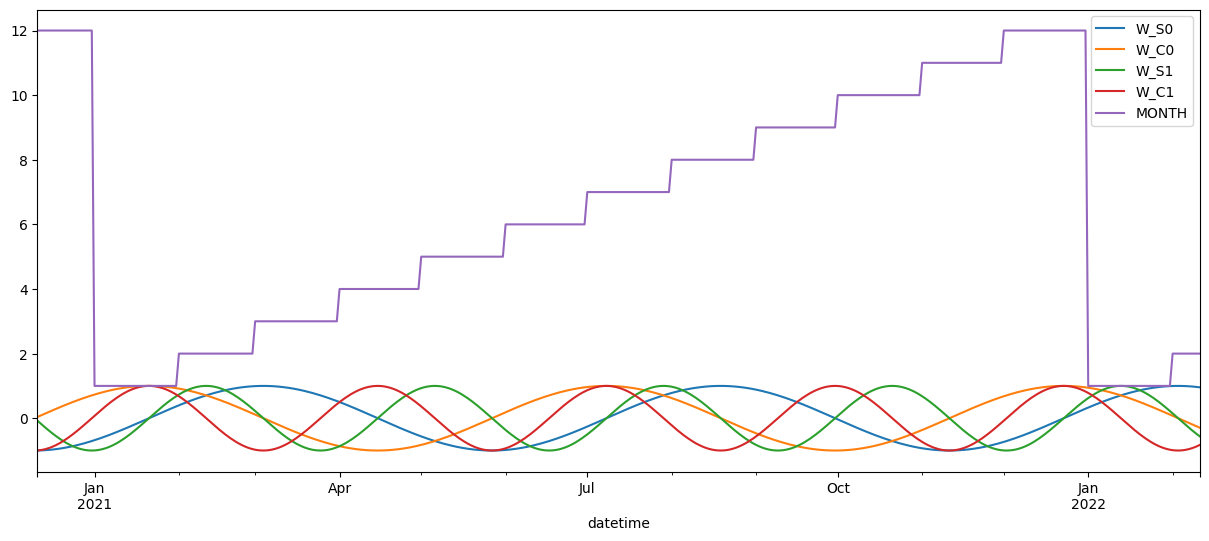

In [53]:
from src.seasonality import FourierTerms

daily_terms = FourierTerms(period=24, n_terms=2, prefix='D_')
weekly_terms = FourierTerms(period=24 * 7, n_terms=2, prefix='W_')
monthly_terms = FourierTerms(period=24 * 30, n_terms=2, prefix='M_')

daily_fourier = daily_terms.transform(train_df.index)
weekly_fourier = weekly_terms.transform(train_df.index)
monthly_fourier = monthly_terms.transform(train_df.index)

weekly_fourier['MONTH'] = train_df.index.month

#daily_fourier.tail(400).plot(figsize=(15,6))
weekly_fourier.plot(figsize=(15,6))

<Axes: xlabel='datetime'>

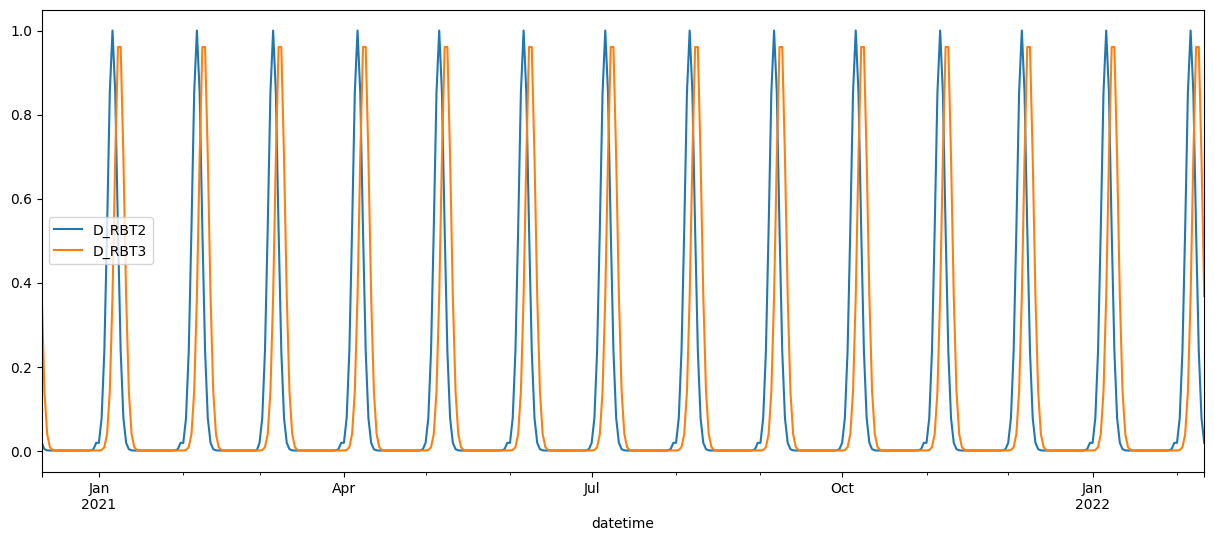

In [54]:
from src.seasonality import RBFTerms

rbf_hour = RBFTerms(n_terms=12, period='.hour', prefix='H_')
rbf_day = RBFTerms(n_terms=12, period='.day', prefix='D_')

rbf_hour.fit(train_df.index)
rbf_day.fit(train_df.index)

rbf_hour_x = rbf_hour.transform(train_df.index)
rbf_day_x = rbf_day.transform(train_df.index)

rbf_day_x.iloc[:,2:4].tail(1400).plot(figsize=(15,6))

In [55]:
from src.seasonality import FourierTerms, RBFTerms

daily_terms = FourierTerms(period=24, n_terms=2, prefix='D_')
weekly_terms = FourierTerms(period=24 * 7, n_terms=2, prefix='W_')
monthly_terms = FourierTerms(period=24 * 30, n_terms=2, prefix='M_')

rbf_hour = RBFTerms(n_terms=12, period='.hour', prefix='H_')
rbf_day = RBFTerms(n_terms=12, period='.day', prefix='D_')

rbf_hour.fit(train_df.index)
rbf_day.fit(train_df.index)

rbf_hour_x = rbf_hour.transform(train_df.index)
rbf_day_x = rbf_day.transform(train_df.index)
daily_fourier = daily_terms.transform(train_df.index)
weekly_fourier = weekly_terms.transform(train_df.index)
monthly_fourier = monthly_terms.transform(train_df.index)

X_exog = pd.concat([X, daily_fourier, weekly_fourier, monthly_fourier,
                    rbf_hour_x, rbf_day_x],
                   ignore_index=False, axis=1)

model_with_terms = RandomForestRegressor()
model_with_terms.fit(X_exog, Y)
model_without_terms = RandomForestRegressor()
model_without_terms.fit(X, Y)



daily_ts_fourier = daily_terms.transform(X_test.index)
weekly_ts_fourier = weekly_terms.transform(X_test.index)
monthly_ts_fourier = monthly_terms.transform(X_test.index)
rbf_hour_ts = rbf_hour.transform(X_test.index)
rbf_day_ts = rbf_day.transform(X_test.index)

X_ts_exog = pd.concat([X_test, daily_ts_fourier,
                       weekly_ts_fourier, monthly_ts_fourier,
                       rbf_hour_ts, rbf_day_ts
                       ],
                      ignore_index=False, axis=1)

preds_with_terms = model_with_terms.predict(X_ts_exog)[0]
preds_without_terms = model_without_terms.predict(X_test)[0]

print(np.mean(abs(test - preds_with_terms)))
print(np.mean(abs(test - preds_without_terms)))

292.662559108293
245.3389504730269


<Axes: >

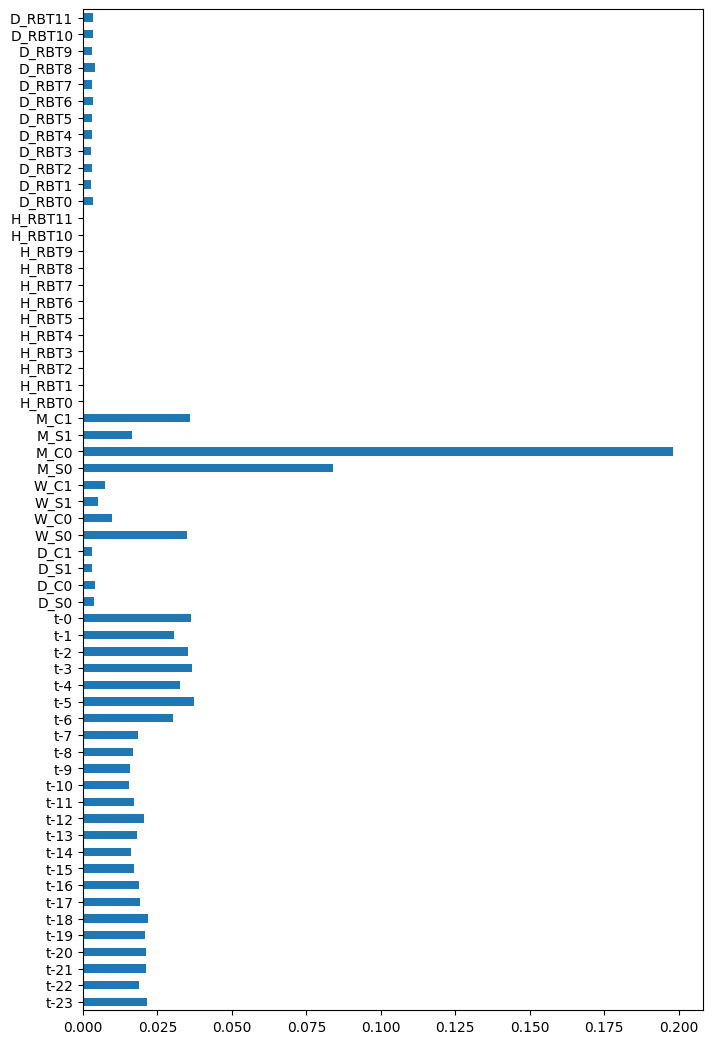

In [56]:
pd.Series(dict(zip(X_exog.columns,model_with_terms.feature_importances_))).plot.barh(figsize=(8,13))

<Axes: >

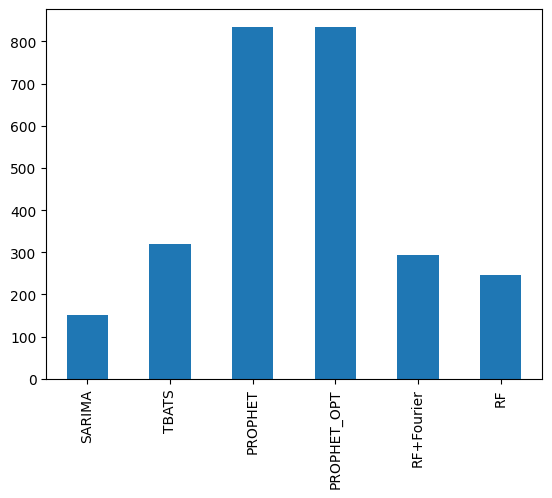

In [57]:
results = {'SARIMA': np.mean(abs(test - y_arima_forecast)),
'TBATS': np.mean(abs(test - y_tbats_forecast)),
'PROPHET': np.mean(abs(test - y_prophet_forecast['yhat'].values)),
'PROPHET_OPT': np.mean(abs(test - y_prophetopt_forecast['yhat'].values)),
'RF+Fourier': np.mean(abs(test - preds_with_terms)),
'RF': np.mean(abs(test - preds_without_terms))
}

pd.Series(results).plot.bar()

# Questão 3

## 3. Avaliar diferentes métodos de aprendizagem máquina com validação cruzada.

In [ ]:
from src.tde import UnivariateTDE

In [ ]:
# prever o próximo valor com base nos 6 anteriores
series_tde = UnivariateTDE(series.diff(), horizon=1, k=6)
series_tde.head()

,t-5,t-4,t-3,t-2,t-1,t-0,t+1
0,1078.437500,955.875000,209.708333,127.500000,26.375000,-603.916667,-636.416667
1,955.875000,209.708333,127.500000,26.375000,-603.916667,-636.416667,588.041667
2,209.708333,127.500000,26.375000,-603.916667,-636.416667,588.041667,654.416667
3,127.500000,26.375000,-603.916667,-636.416667,588.041667,654.416667,68.125000
4,26.375000,-603.916667,-636.416667,588.041667,654.416667,68.125000,-4.833333


In [ ]:
# separar variáveis explicativas da variável objetivo
X = series_tde.drop('t+1', axis=1)
y = series_tde['t+1']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [ ]:
X_train.head()

,t-5,t-4,t-3,t-2,t-1,t-0
0,1078.437500,955.875000,209.708333,127.500000,26.375000,-603.916667
1,955.875000,209.708333,127.500000,26.375000,-603.916667,-636.416667
2,209.708333,127.500000,26.375000,-603.916667,-636.416667,588.041667
3,127.500000,26.375000,-603.916667,-636.416667,588.041667,654.416667
4,26.375000,-603.916667,-636.416667,588.041667,654.416667,68.125000


In [ ]:
y_train.head()

0   -636.416667
1    588.041667
2    654.416667
3     68.125000
4     -4.833333
Name: t+1, dtype: float64

## Estimação de Desempenho

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
cv = TimeSeriesSplit(n_splits=5)

cv_err = []
for tr_idx, ts_idx in cv.split(X_train, y_train):
    print('Training indices:')
    print(tr_idx[-5:])
    X_tr = X_train.values[tr_idx]
    y_tr = y_train.values[tr_idx]

    X_vl = X_train.values[ts_idx]
    y_vl = y_train.values[ts_idx]

    print('Training the model')
    model = Ridge()

    model.fit(X_tr, y_tr)
    print('Making predictions')
    pred = model.predict(X_vl)

    print('Computing error')
    err = mean_absolute_error(y_vl, pred)
    cv_err.append(err)


print(cv_err)

Training indices:
[58 59 60 61 62]
Training the model
Making predictions
Computing error
Training indices:
[121 122 123 124 125]
Training the model
Making predictions
Computing error
Training indices:
[184 185 186 187 188]
Training the model
Making predictions
Computing error
Training indices:
[247 248 249 250 251]
Training the model
Making predictions
Computing error
Training indices:
[310 311 312 313 314]
Training the model
Making predictions
Computing error
[177.8356404552019, 161.35941977731198, 162.07756954250928, 154.6580635753684, 192.34365698682595]


In [ ]:
# erro estimado em validação cruzada
print(f'Average error is: {np.mean(cv_err)}')

Average error is: 169.6548700674435


In [ ]:
# erro que obtemos no teste
model = Ridge()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 165.21586030159548


## Seleção de Modelo

In [1]:
import plotly.express as px
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from pprint import pprint
import numpy as np
import time

# Constants
CV_FOLDS = 5
SCORING_METRIC = 'neg_mean_absolute_error'

# Run cross-validation and return mean error
def run_cross_validation(model, X, y, cv_folds, scoring_metric):
    start_time = time.time()
    cv_error = cross_val_score(model, X, y, cv=cv_folds, scoring=scoring_metric)
    elapsed_time = time.time() - start_time

    print(f"Time elapsed: {elapsed_time:.2f} seconds")
    return -np.mean(cv_error)

# Initialize models
model_dict = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
}

# Store mean errors
mean_errors = {}

# Run cross-validation
for model_name, model_instance in model_dict.items():
    print(f'Running model: {model_name}')
    mean_error = run_cross_validation(model_instance, X_train, y_train, CV_FOLDS, SCORING_METRIC)
    mean_errors[model_name] = mean_error
    print(f"Mean Absolute Error for {model_name}: {mean_error:.2f}")

# Plotting with Plotly
fig = px.bar(x=list(mean_errors.keys()), y=list(mean_errors.values()), title="Mean Absolute Error by Model")
fig.show()

# Pretty print results
pprint(mean_errors)


Running model: Ridge


NameError: ignored

In [ ]:
model_list = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
}

from sklearn.model_selection import cross_val_score

In [ ]:
err_by_method = {}
for method in model_list:
    print(f'Running model: {method}')
    cv_error = cross_val_score(model_list[method],
                               X_train,
                               y_train,
                               cv=cv,
                               scoring='neg_mean_absolute_error')

    err_by_method[method] = -np.mean(cv_error)

Running model: Ridge
Running model: Lasso
Running model: RandomForestRegressor
Running model: DecisionTreeRegressor
Running model: KNeighborsRegressor


<Axes: >

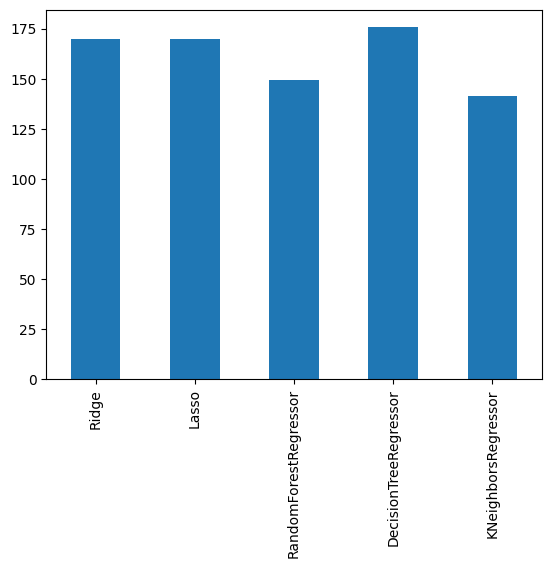

In [ ]:
pd.Series(err_by_method).plot.bar()

In [ ]:
from pprint import pprint
pprint(err_by_method)

{'DecisionTreeRegressor': 175.68650793650798,
 'KNeighborsRegressor': 141.53413250517596,
 'Lasso': 169.65415861857818,
 'RandomForestRegressor': 149.34262111801243,
 'Ridge': 169.6548700674435}


##  Seleção de Parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 5, 10]}

model = KNeighborsRegressor()
cv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           cv=cv,
                           refit=True)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 5, 10],
                         'weights': ['uniform', 'distance']})

In [ ]:
grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator
import numpy as np
import logging
import math

logging.basicConfig(level=logging.INFO)

def evaluate_model(grid_search_model: BaseEstimator, X_test_data: np.ndarray, y_test_data: np.ndarray) -> dict:
    try:
        predicted_test_values = grid_search_model.predict(X_test_data)
        if predicted_test_values.shape != y_test_data.shape:
            logging.warning("Shape mismatch between predicted and actual values. Make sure they align.")
            return None

        mae = mean_absolute_error(y_test_data, predicted_test_values)
        rmse = math.sqrt(mean_squared_error(y_test_data, predicted_test_values))
        r2 = r2_score(y_test_data, predicted_test_values)

        logging.info(f'Mean Absolute Error (MAE) on Test Data: {mae}')
        logging.info(f'Root Mean Square Error (RMSE) on Test Data: {rmse}')
        logging.info(f'R-squared (R2) on Test Data: {r2}')

        return {"MAE": mae, "RMSE": rmse, "R2": r2}

    except Exception as e:
        logging.error(f"An error occurred: {e}")
        return None

def show_data_scale(y_train_data: np.ndarray, y_test_data: np.ndarray):
    combined_data = np.concatenate([y_train_data, y_test_data])

    print(f"Minimum value of target data: {np.min(combined_data)}")
    print(f"Maximum value of target data: {np.max(combined_data)}")
    print(f"Mean value of target data: {np.mean(combined_data)}")
    print(f"Standard Deviation of target data: {np.std(combined_data)}")

# Assuming grid_search, X_test, y_test, and y_train are defined and appropriate
if __name__ == "__main__":
    show_data_scale(y_train, y_test)

    error_metrics = evaluate_model(grid_search, X_test, y_test)

    if error_metrics is not None:
        print(f'Mean Absolute Error (MAE) on Test Data: {error_metrics["MAE"]}')
        print(f'Root Mean Square Error (RMSE) on Test Data: {error_metrics["RMSE"]}')
        print(f'R-squared (R2) on Test Data: {error_metrics["R2"]}')
    else:
        print("Evaluation failed. Check logs for more details.")


Minimum value of target data: -774.0
Maximum value of target data: 1051.583333333333
Mean value of target data: -1.417695473251029
Standard Deviation of target data: 445.670280997741
Mean Absolute Error (MAE) on Test Data: 109.75645153346147
Root Mean Square Error (RMSE) on Test Data: 180.1492239174279
R-squared (R2) on Test Data: 0.836048583337659


# Questão 4

## 4. Analisar os resultados obtidos no ponto 3

In [ ]:
from src.tde import UnivariateTDE

In [ ]:
# desta vez fazemos a divisão no tempo
train_end = pd.Timestamp('2021-12-01')
test_start = pd.Timestamp('2021-12-02')

In [ ]:
training, testing, mean_value = {}, {}, {}

# últimos 6 meses para validação
train = series.loc[:train_end]
test = series.loc[test_start:]

# normalização com dados de TREINO!
mean_value = train.mean()
train /= mean_value
test /= mean_value

# série temporal como matriz
training = UnivariateTDE(train, horizon=1, k=4)
testing = UnivariateTDE(test, horizon=1, k=4)

In [ ]:
training.head()

,t-3,t-2,t-1,t-0,t+1
0,0.763697,0.955469,1.125446,1.162738,1.185410
1,0.955469,1.125446,1.162738,1.185410,1.190100
2,1.125446,1.162738,1.185410,1.190100,1.082710
3,1.162738,1.185410,1.190100,1.082710,0.969540
4,1.185410,1.190100,1.082710,0.969540,1.074107


In [ ]:
X_train = training.drop('t+1', axis=1)
y_train = training['t+1']

In [ ]:
from sklearn.linear_model import Ridge
# treinando o modelo global
global_model = Ridge()
global_model.fit(X_train, y_train)

Ridge()

In [ ]:
# previsão
X_test = testing.drop('t+1', axis=1)
global_forecasts = global_model.predict(X_test)
# revertendo a normalização
global_forecasts *= mean_value

In [ ]:
X_train_local = training.drop('t+1', axis=1)
y_train_local = training['t+1']

# treinando o modelo local
local_model = Ridge()
local_model.fit(X_train_local, y_train_local)

Ridge()

In [ ]:
# previsão
X_test = testing.drop('t+1', axis=1)
local_forecasts = local_model.predict(X_test)

local_forecasts *= mean_value

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(testing['t+1'], global_forecasts)


0.05799270975597925

In [ ]:
mean_absolute_error(testing['t+1'], local_forecasts)

0.05799270975597925

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inicialize um dicionário para armazenar os erros para diferentes horizontes de previsão
errors = {'Horizon': [], 'MAE': [], 'RMSE': []}

# Experimente com diferentes horizontes de previsão
for horizon in range(1, 11):  # de 1 a 10 passos à frente
    print(f"Horizon: {horizon}")

    # Prepare os dados
    training = UnivariateTDE(train, horizon=horizon, k=4)
    testing = UnivariateTDE(test, horizon=horizon, k=4)

    X_train = training.drop(f't+{horizon}', axis=1)
    y_train = training[f't+{horizon}']
    X_test = testing.drop(f't+{horizon}', axis=1)
    y_test = testing[f't+{horizon}']

    # Treine o modelo
    model = Ridge()
    model.fit(X_train, y_train)

    # Faça previsões
    forecasts = model.predict(X_test)

    # Calcule o erro
    mae = mean_absolute_error(y_test, forecasts)
    rmse = np.sqrt(mean_squared_error(y_test, forecasts))

    print(f"MAE: {mae}, RMSE: {rmse}")

    # Armazene os erros
    errors['Horizon'].append(horizon)
    errors['MAE'].append(mae)
    errors['RMSE'].append(rmse)

# Converta o dicionário de erros em um DataFrame para facilitar a análise
import pandas as pd
df_errors = pd.DataFrame(errors)


Horizon: 1
MAE: 0.057992709755979165, RMSE: 0.07058122522852686
Horizon: 2
MAE: 0.053876830787654574, RMSE: 0.06681246320594764
Horizon: 3
MAE: 0.037864575965922964, RMSE: 0.05011363170069563
Horizon: 4
MAE: 0.03428231060289716, RMSE: 0.04494560710227884
Horizon: 5
MAE: 0.03302246248097547, RMSE: 0.043591218478887965
Horizon: 6
MAE: 0.032311692116566704, RMSE: 0.042614822636172445
Horizon: 7
MAE: 0.03219810376405818, RMSE: 0.04257807977950656
Horizon: 8
MAE: 0.0316971312488362, RMSE: 0.04186543939291551
Horizon: 9
MAE: 0.03137249752276159, RMSE: 0.04148758257951071
Horizon: 10
MAE: 0.03086589645164211, RMSE: 0.040624852236093405


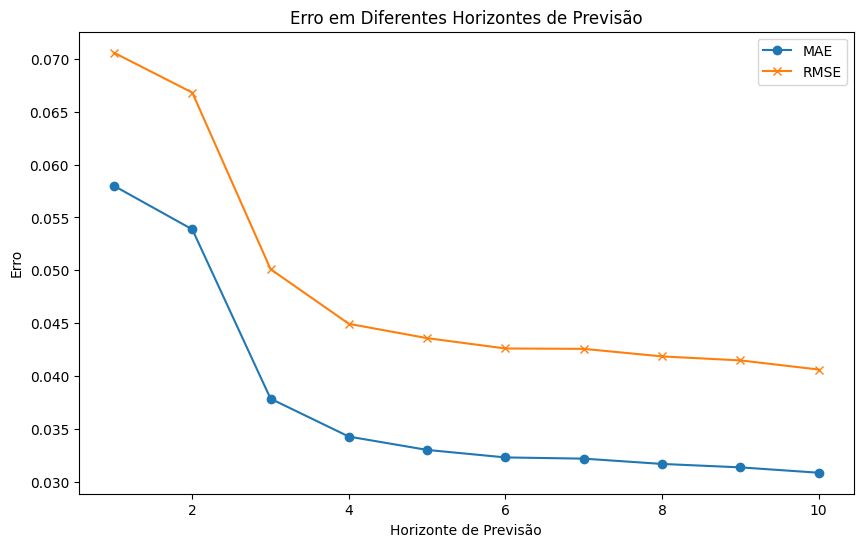

In [ ]:
import matplotlib.pyplot as plt

# Dados dos erros para diferentes horizontes de previsão
horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mae_values = [0.057992709755979165, 0.053876830787654574, 0.037864575965922964, 0.03428231060289716, 0.03302246248097547, 0.032311692116566704, 0.03219810376405818, 0.0316971312488362, 0.03137249752276159, 0.03086589645164211]
rmse_values = [0.07058122522852686, 0.06681246320594764, 0.05011363170069563, 0.04494560710227884, 0.043591218478887965, 0.042614822636172445, 0.04257807977950656, 0.04186543939291551, 0.04148758257951071, 0.040624852236093405]

plt.figure(figsize=(10, 6))

# Plotar MAE
plt.plot(horizons, mae_values, label='MAE', marker='o')

# Plotar RMSE
plt.plot(horizons, rmse_values, label='RMSE', marker='x')

plt.xlabel('Horizonte de Previsão')
plt.ylabel('Erro')
plt.title('Erro em Diferentes Horizontes de Previsão')
plt.legend()

plt.show()


## 1. Descrever o impacto dos seguintes aspectos no desempenho preditivo:


 ### 1-  Diferentes Horizontes de Previsão
   Com base nos dados fornecidos, observa-se uma tendência geral de diminuição do erro (tanto MAE quanto RMSE) à medida que o horizonte de previsão aumenta. Isto pode ser devido a várias razões. Pode ser que o modelo capture melhor as relações temporais a longo prazo, ou que as características usadas sejam mais relevantes para previsões de longo prazo.
  Horizonte 1: MAE = 0.058, RMSE = 0.071
  Horizonte 10: MAE = 0.031, RMSE = 0.041
  A diferença entre os erros de curto prazo e de longo prazo é significativa, o que sugere que o modelo é mais preciso para previsões de longo prazo.



 ### 2 - Desempenho nos Valores Extremos:
   Para avaliar o desempenho nos valores extremos, pode-se observar o RMSE, que é mais sensível aos outliers do que o MAE. Como o RMSE está diminuindo com o aumento do horizonte de previsão, pode-se especular que o modelo lida bem com valores extremos. No entanto, para uma avaliação precisa, seria útil plotar resíduos ou fazer uma análise mais detalhada dos erros em relação aos valores reais extremos.



### 3- Diferentes Algoritmos de Aprendizagem de Máquina
    DecisionTreeRegressor: 175.69
    KNeighborsRegressor: 141.53
    Lasso: 169.65
    RandomForestRegressor: 149.34
    Ridge: 169.65
   Estes valores sugerem que diferentes algoritmos têm desempenhos variados, com o KNeighborsRegressor e o RandomForestRegressor tendo os erros MAE mais baixos. Isso pode indicar que métodos baseados em vizinhos ou emsembles podem ser mais eficazes para este problema específico.